<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/mnist_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Generativas Adversariales (GANs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Creación de caracteres manuscritos nuevos entrenando con MNIST:**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Modelos Deep Learning**</h1></font>

In [ ]:
COLAB                  = True
SAVE_INTERMEDIATE_DATA = False

In [ ]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

%matplotlib inline

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 19.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Using TensorFlow backend.


In [ ]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

In [ ]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100//5 # sin //5 ok

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255 # para que esté entre 0 y 1
X_train = 2*X_train - 1 # para que esté entre -1 y 1
print(X_train.shape)

X_train = X_train.reshape(X_train.shape + (1,))
print(X_train.shape)

X_train = X_train[y_train<5] # para simplificar se entrena sólo con los dígitos 0,1,2,3,4
y_train = y_train[y_train<5] # ídem

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.33, random_state=0)

In [ ]:
X_train.shape

(30596, 28, 28, 1)

**Optimizador**

In [ ]:
#adam = Adam(lr=0.0002, beta_1=0.5)
adam_gen  = Adam(lr=0.0002, beta_1=0.5)
adam_disc = Adam(lr=0.0002/2, beta_1=0.5) # Uso el discriminador con un learning rate menor que el del generador

**Generador**

In [ ]:
randomDim

20

In [ ]:
generator = Sequential()

# rellenar --> Armo el generador a partir del discriminador (armamos antes ese, mirarlo antes que este)
# La entrada al generador es un vector --> Tengo que meter una capa Densa. Las imágenes tienen que ser de 7x7
generator.add(Dense(7*7*32, input_shape=(randomDim,),
                    kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(Reshape((7,7,32))) # Generar 32 imágenes de 7x7 --> ver que la capa densa la convierto en esto, es como un anti-Flatten()
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2,2))) # 32 imágenes de 14x14 --> este paso es como un maxpooling inverso
generator.add(Conv2D(8, kernel_size=(5,5), padding='same')) # 8 imágenes de 14x14
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2,2))) # 8 imágenes de 28x28 --> este paso es como un maxpooling inverso
generator.add(Conv2D(1, kernel_size=(5,5), 
                     padding='same', activation='tanh')) # 1 imagen de 28x28 --> obs: nada hasta ahora me garantiza que los valores estén entre -1 y 1, por eso uso tanh
generator.compile(loss="binary_crossentropy",
                  optimizer=adam_gen)

generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1568)              32928     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         6408      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 8)        

**Discriminador**

In [ ]:
from keras.layers import MaxPool2D

In [ ]:
discriminator = Sequential()

# rellenar
discriminator.add(Conv2D(16, kernel_size=(5,5), padding='same', input_shape=(28, 28, 1), 
                         kernel_initializer=initializers.RandomNormal(stddev=0.02))) # El initializer con esa distribución hace que la red del discriminador inicie con
                                                                                     # pesos muy pequeños. Hace que la red no pueda arrancar bien ni por casualidad.
# La salida en este punto es de 16 imágenes de 28x28
discriminator.add(LeakyReLU(0.2)) # función de activación LeakyReLU va por fuera
discriminator.add(MaxPool2D((2,2)))
# La salida en este punto es de 16 imágenes de 14x14
discriminator.add(Conv2D(32, kernel_size=(5,5), padding='same', 
                         kernel_initializer=initializers.RandomNormal(stddev=0.02))) # El initializer con esa distribución hace que la red del discriminador inicie con
                                                                                     # pesos muy pequeños. Hace que la red no pueda arrancar bien ni por casualidad.
# La salida en este punto es de 32 imágenes de 14x14
discriminator.add(LeakyReLU(0.2)) # función de activación LeakyReLU va por fuera
discriminator.add(MaxPool2D((2,2)))
# La salida en este punto es de 32 imágenes de 7x7
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())  # Vector de 32x7x7 = 1568
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss="binary_crossentropy",
                      optimizer=adam_disc)

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)         

**Red combinada (sistema GAN)**

In [ ]:
# rellenar

discriminator.trainable = False

ganInput = Input(shape=(randomDim,))
ganOutput = discriminator(generator(ganInput))
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss="binary_crossentropy",
            optimizer=adam_gen)

gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 28, 28, 1)         39537     
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 14817     
Total params: 54,354
Trainable params: 39,537
Non-trainable params: 14,817
_________________________________________________________________


In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 3))
    plt.plot(range(1,len(dLosses)+1), dLosses,
             label='Discriminitive loss', linewidth=3)
    plt.plot(range(1,len(gLosses)+1), gLosses,
             label='Generative loss', linewidth=3)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=14)
    if not COLAB:
        plt.savefig('./images/dcgan_loss_epoch_{}.png'.format(epoch))
    plt.show()

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
#        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.imshow(generatedImages[i,:,:,0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    if SAVE_INTERMEDIATE_DATA:
        plt.savefig('./images/dcgan_generated_image_epoch_{}.png'.format(epoch))
    plt.show()

    
def plotImages(images, nrows, ncols, figsize):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i,:,:,0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('models/dcgan_discriminator_epoch_{}.h5'.format(epoch))

In [ ]:
if SAVE_INTERMEDIATE_DATA:
    os.makedirs("./images", exist_ok=True)
    os.makedirs("./models", exist_ok=True)

In [ ]:
dLosses = [] # histórico de los valores de la función de coste del discriminador
gLosses = [] # histórico de los valores de la función de coste del generador

Epochs: 50
Batch size: 128
Batches per epoch: 239
--------------- Epoch 1 ---------------


  0%|          | 0/239 [00:00<?, ?it/s]

100%|██████████| 239/239 [00:13<00:00, 18.17it/s]


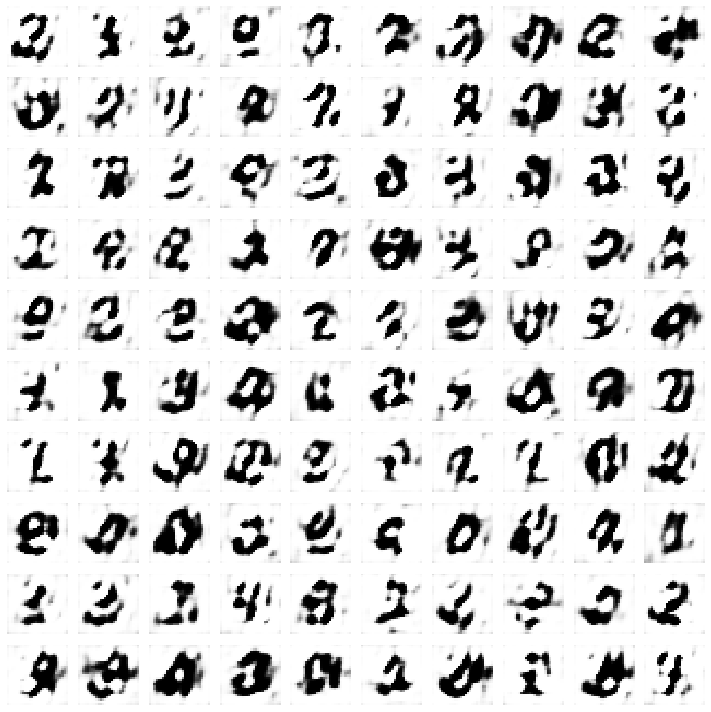

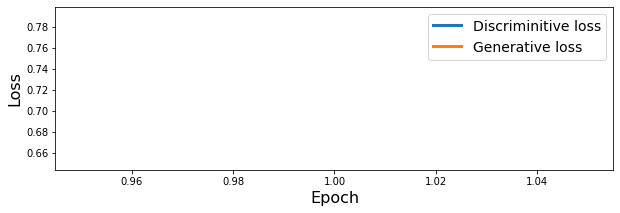

--------------- Epoch 2 ---------------


100%|██████████| 239/239 [00:04<00:00, 49.40it/s]


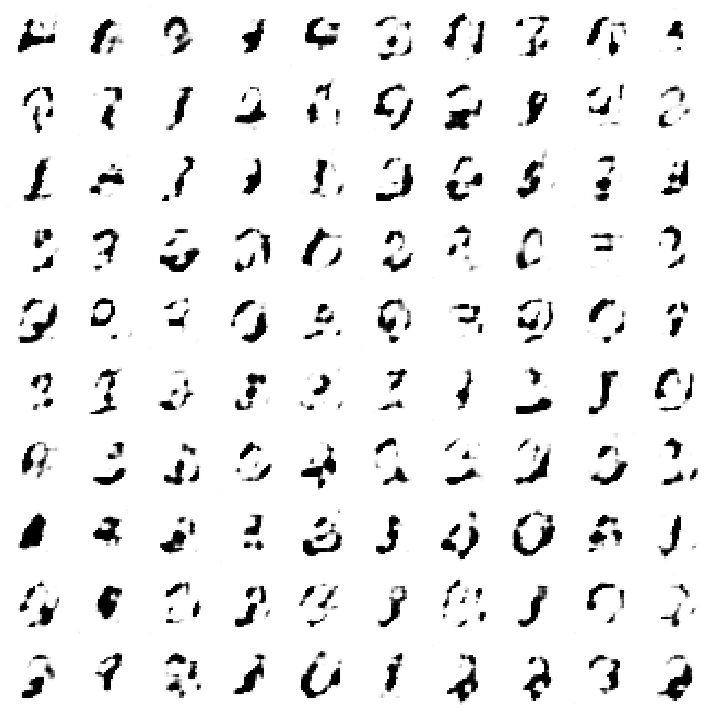

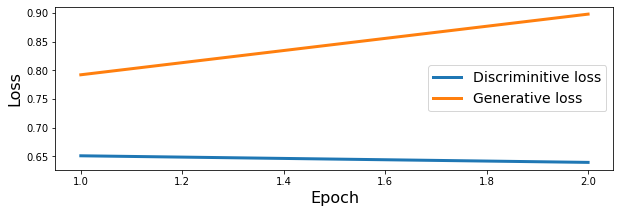

--------------- Epoch 3 ---------------


100%|██████████| 239/239 [00:04<00:00, 49.01it/s]


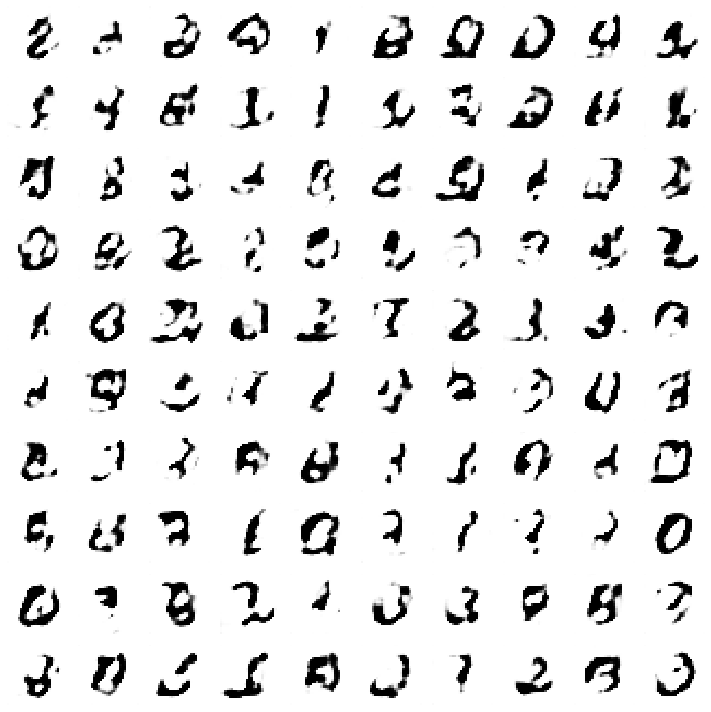

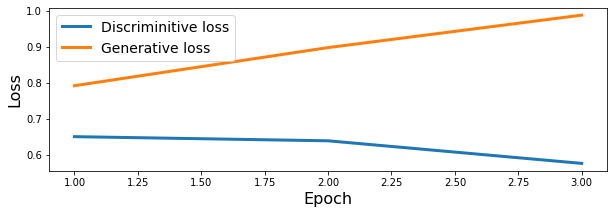

--------------- Epoch 4 ---------------


100%|██████████| 239/239 [00:04<00:00, 49.10it/s]


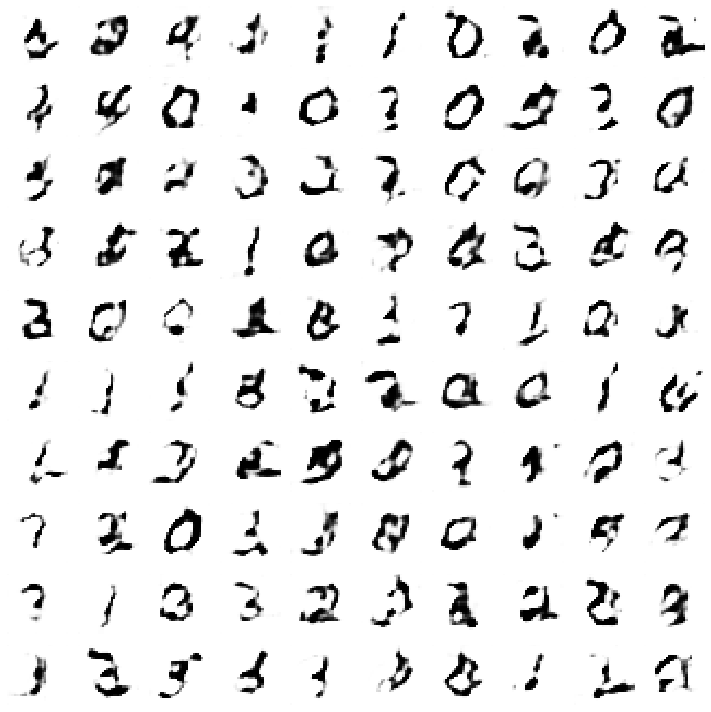

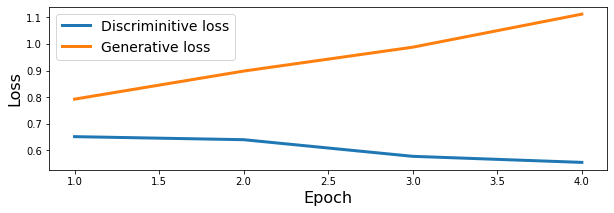

--------------- Epoch 5 ---------------


100%|██████████| 239/239 [00:05<00:00, 47.13it/s]


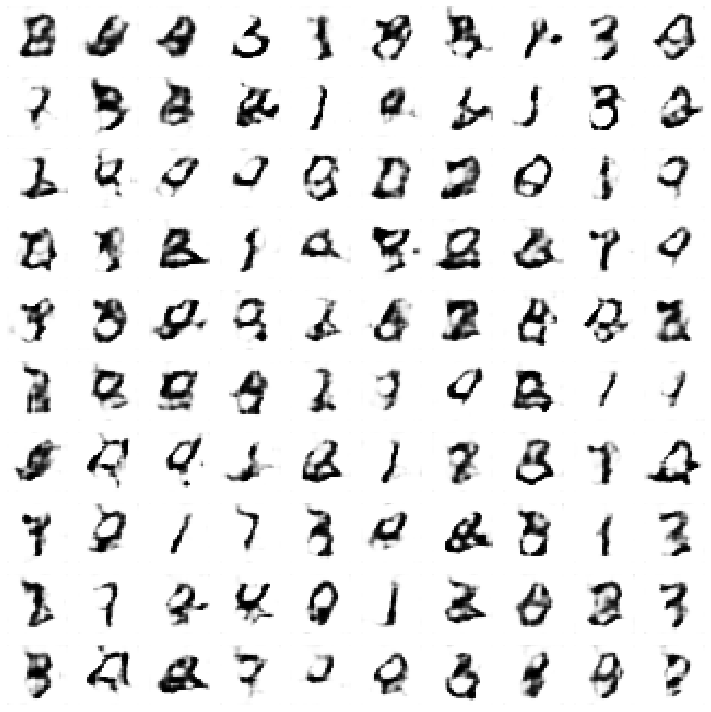

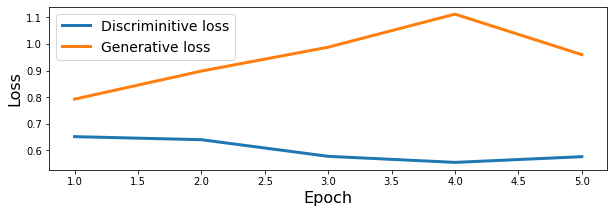

--------------- Epoch 6 ---------------


100%|██████████| 239/239 [00:05<00:00, 46.97it/s]


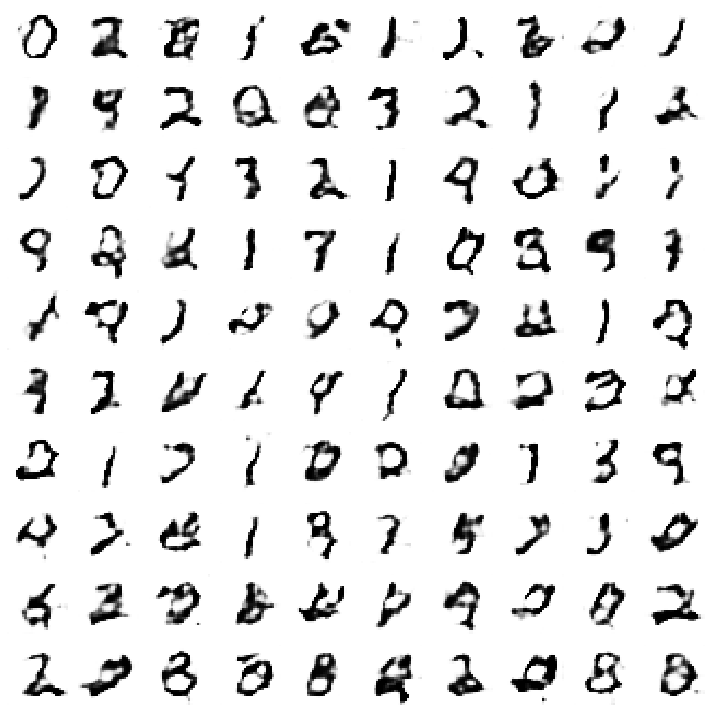

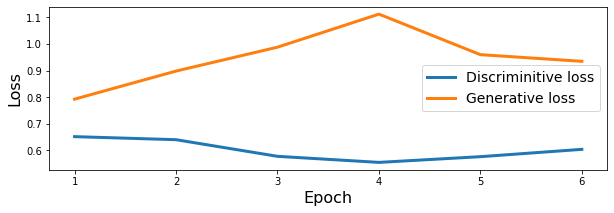

--------------- Epoch 7 ---------------


100%|██████████| 239/239 [00:05<00:00, 47.10it/s]


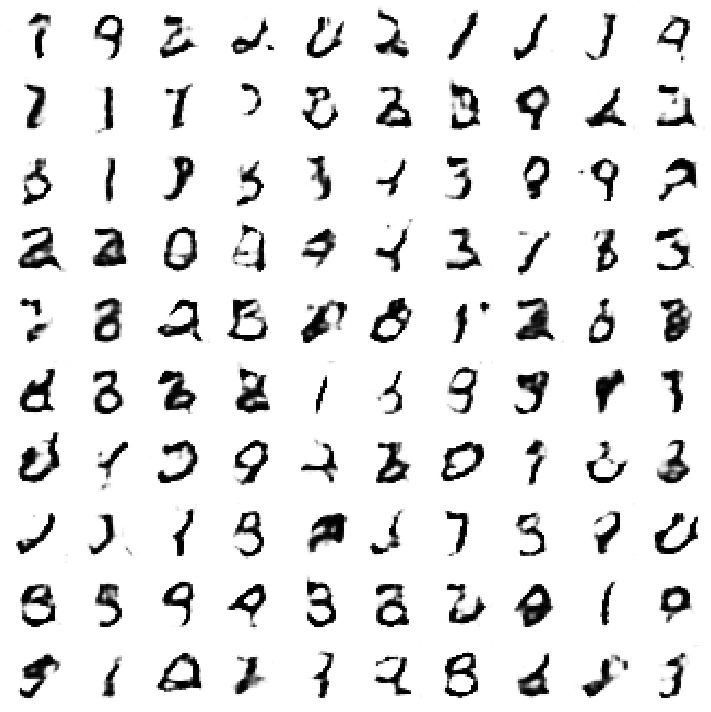

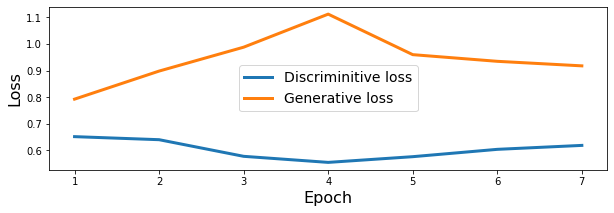

--------------- Epoch 8 ---------------


100%|██████████| 239/239 [00:05<00:00, 46.53it/s]


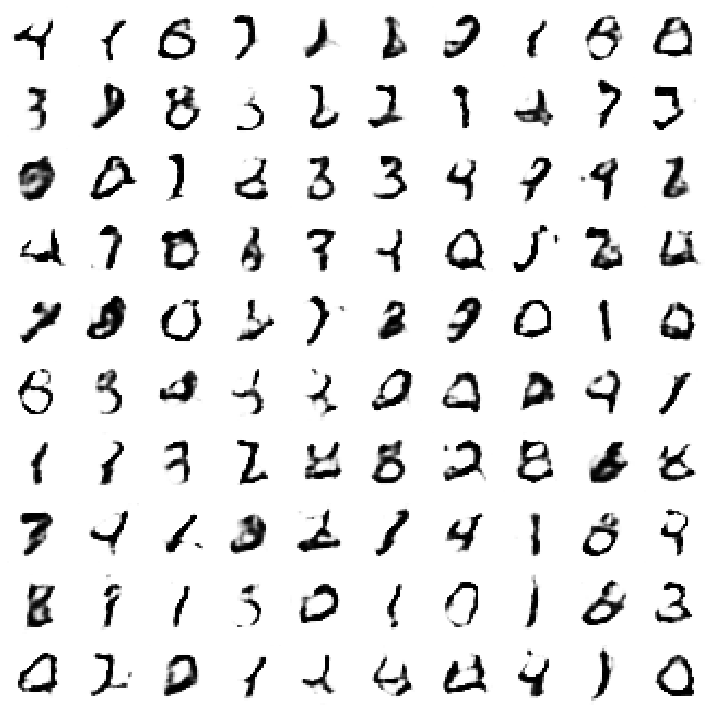

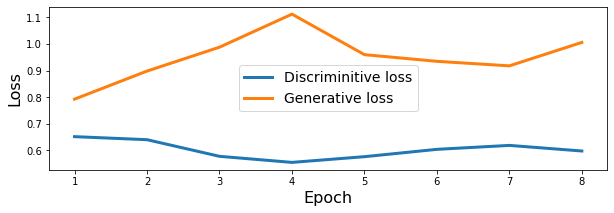

--------------- Epoch 9 ---------------


100%|██████████| 239/239 [00:05<00:00, 45.99it/s]


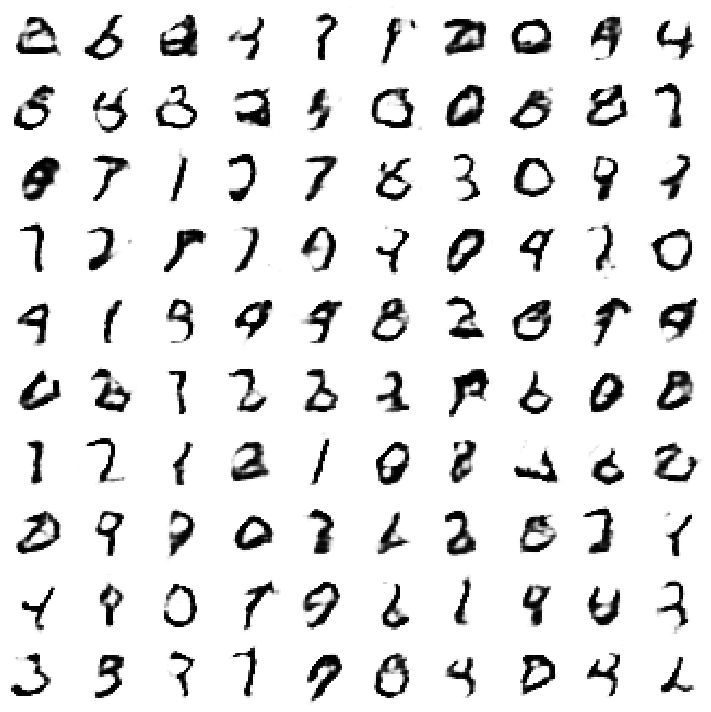

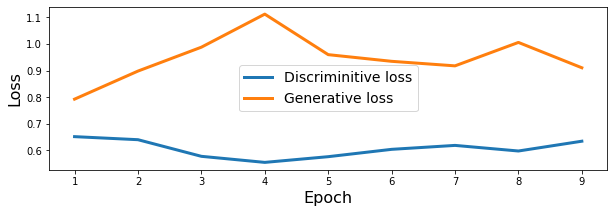

--------------- Epoch 10 ---------------


100%|██████████| 239/239 [00:05<00:00, 45.53it/s]


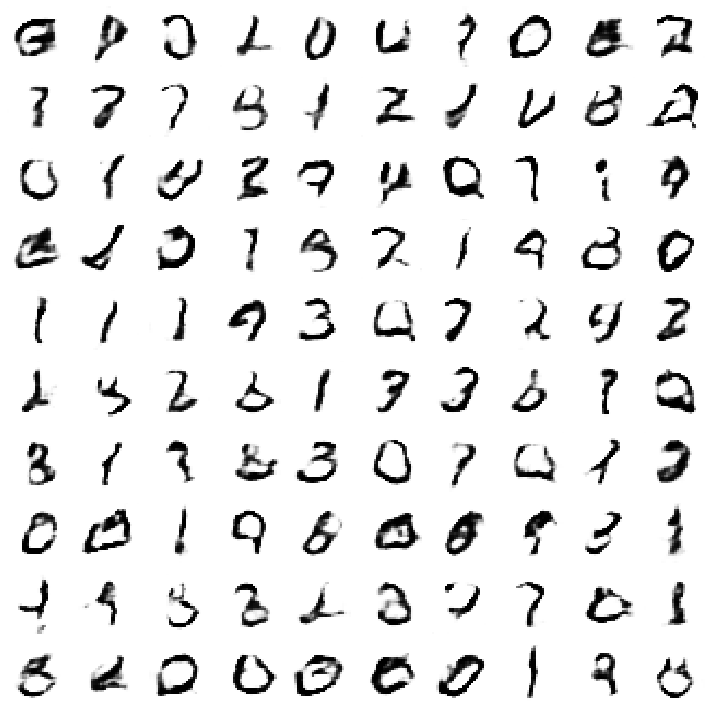

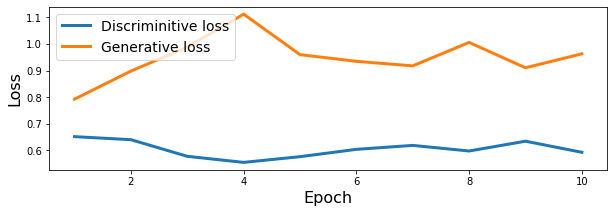

--------------- Epoch 11 ---------------


100%|██████████| 239/239 [00:05<00:00, 45.30it/s]


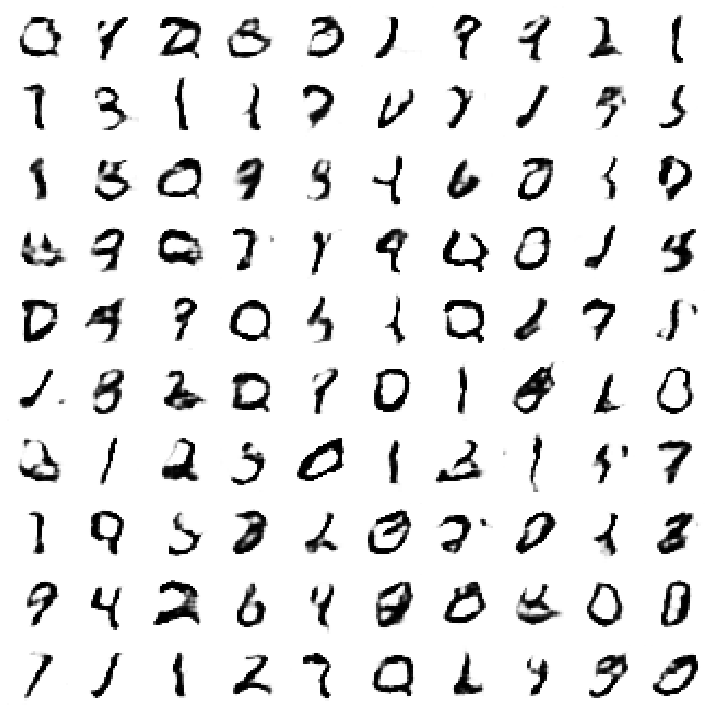

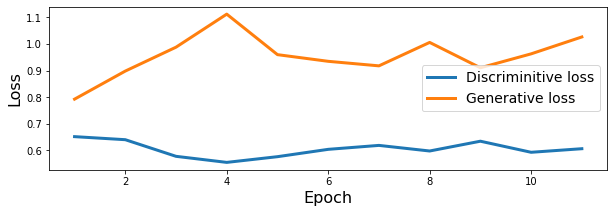

--------------- Epoch 12 ---------------


100%|██████████| 239/239 [00:05<00:00, 44.74it/s]


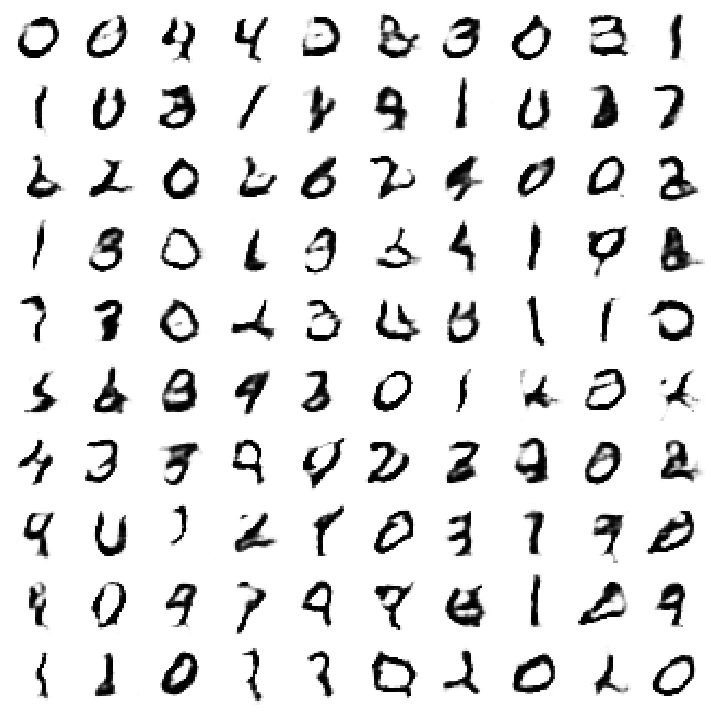

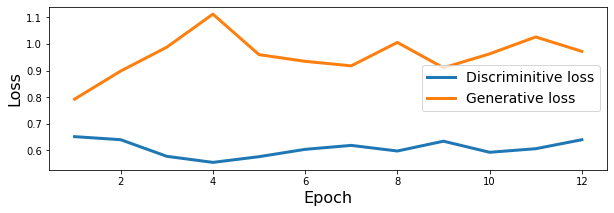

--------------- Epoch 13 ---------------


100%|██████████| 239/239 [00:05<00:00, 44.65it/s]


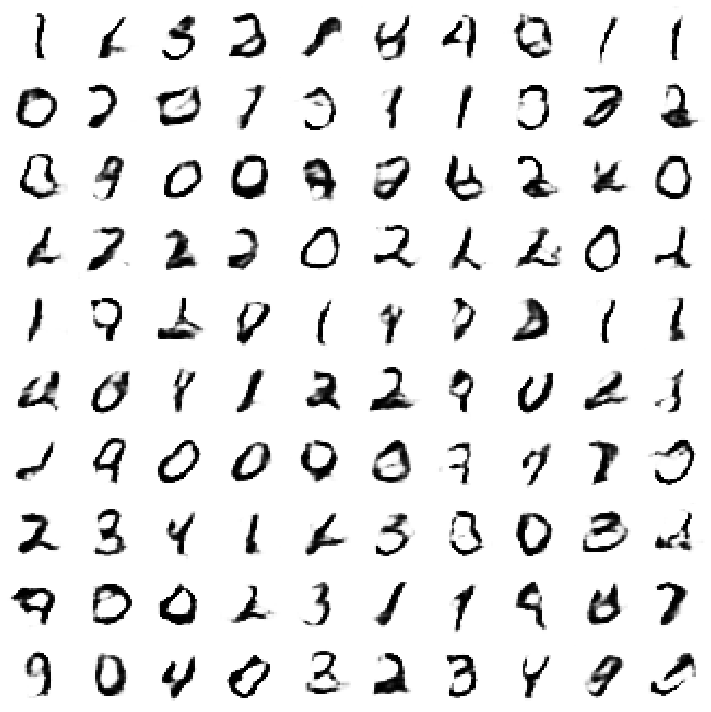

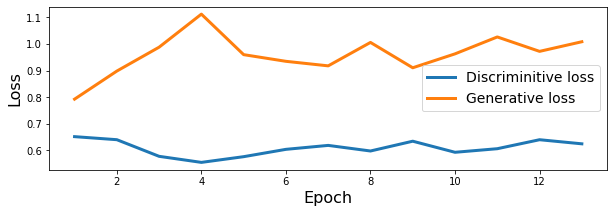

--------------- Epoch 14 ---------------


100%|██████████| 239/239 [00:05<00:00, 44.88it/s]


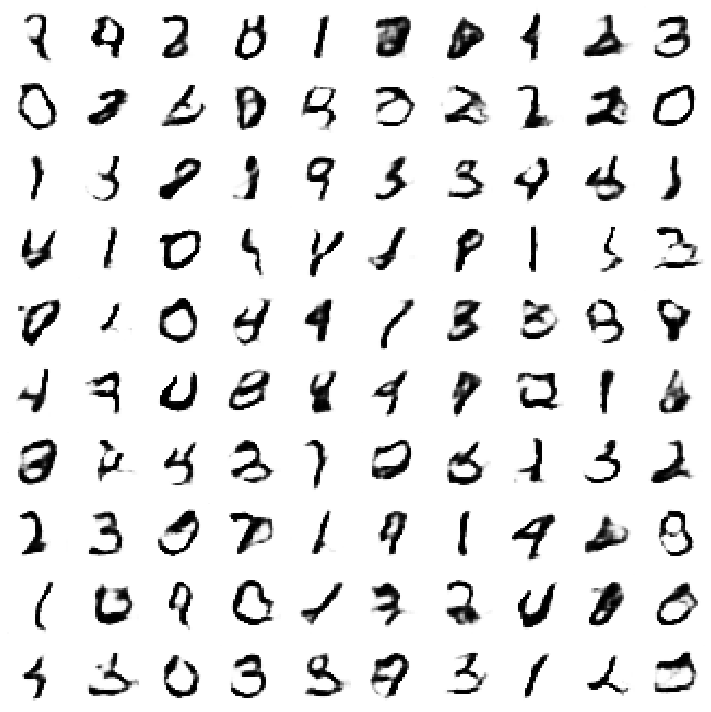

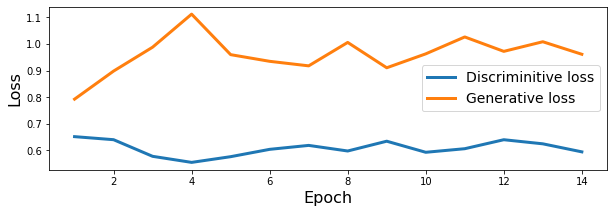

--------------- Epoch 15 ---------------


100%|██████████| 239/239 [00:05<00:00, 44.01it/s]


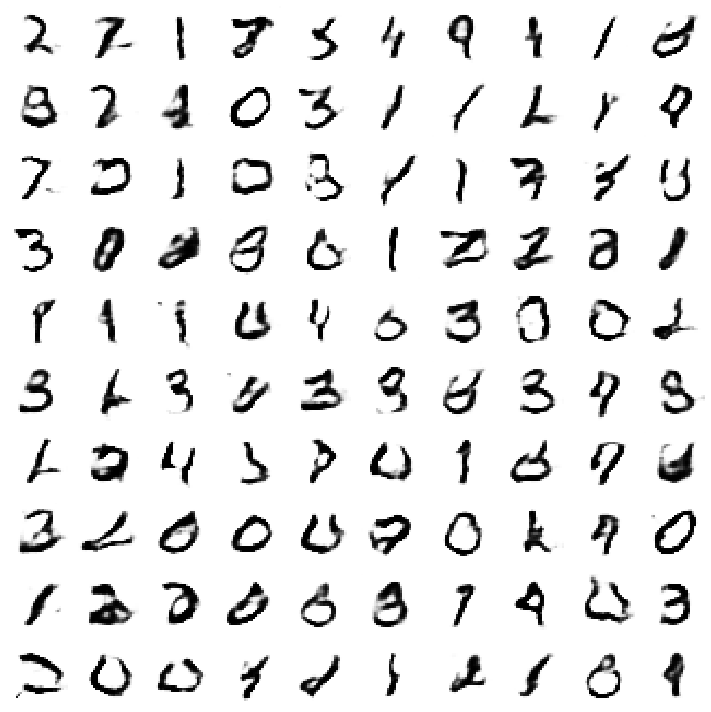

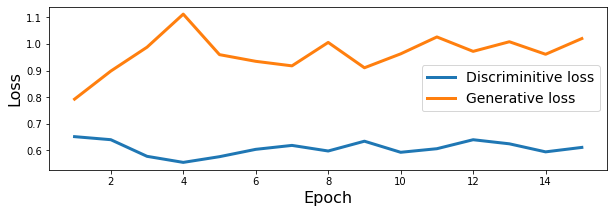

--------------- Epoch 16 ---------------


100%|██████████| 239/239 [00:05<00:00, 43.62it/s]


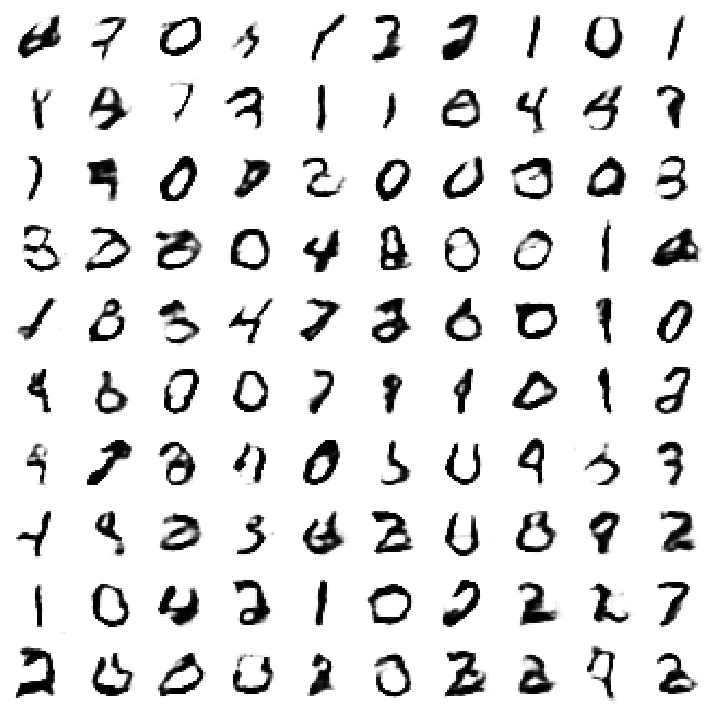

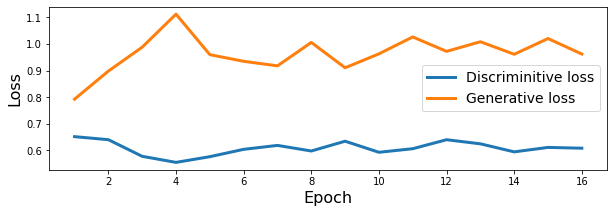

--------------- Epoch 17 ---------------


100%|██████████| 239/239 [00:05<00:00, 43.00it/s]


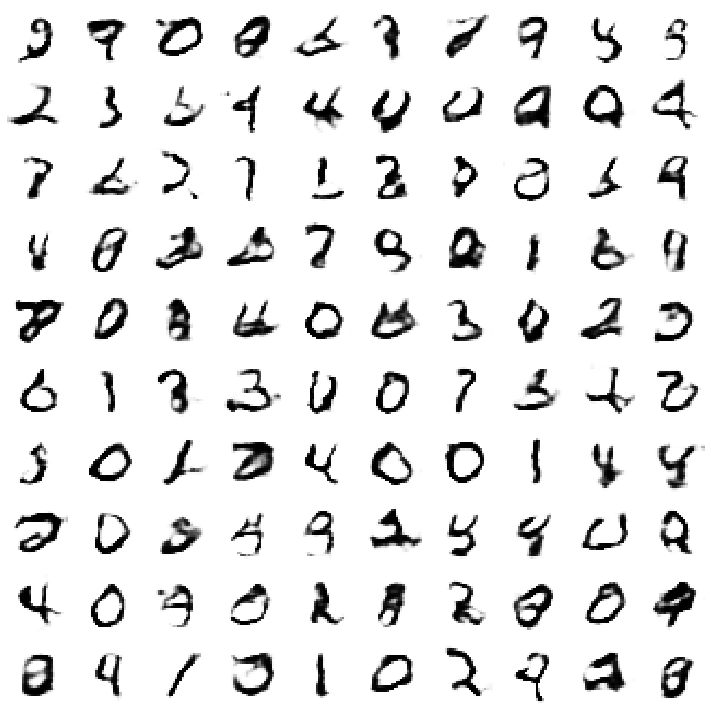

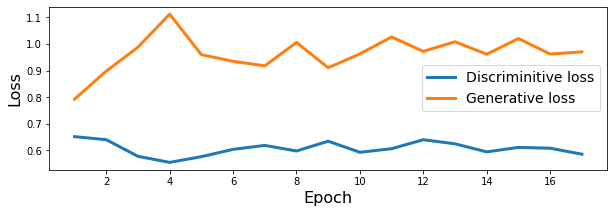

--------------- Epoch 18 ---------------


100%|██████████| 239/239 [00:05<00:00, 42.32it/s]


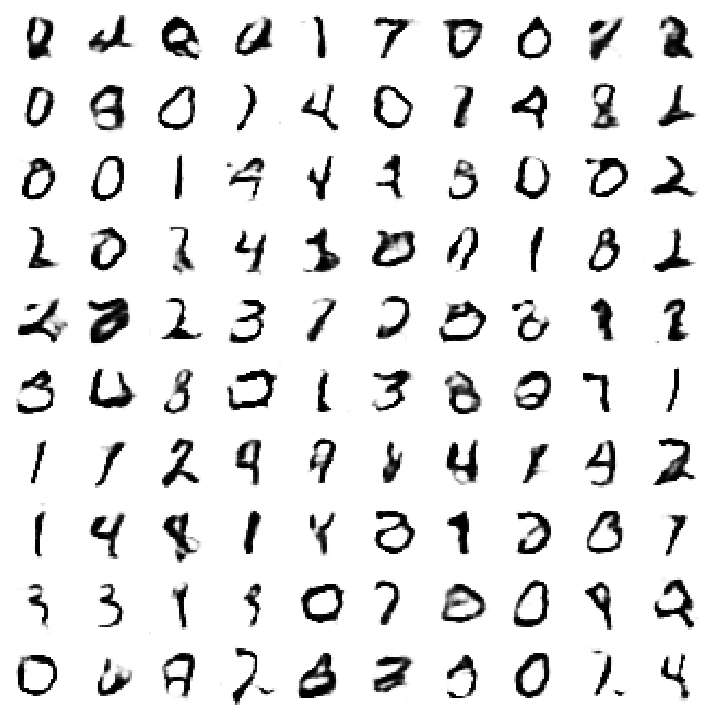

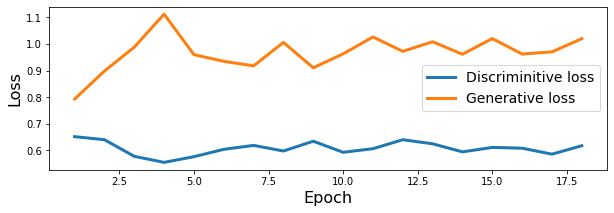

--------------- Epoch 19 ---------------


100%|██████████| 239/239 [00:05<00:00, 42.88it/s]


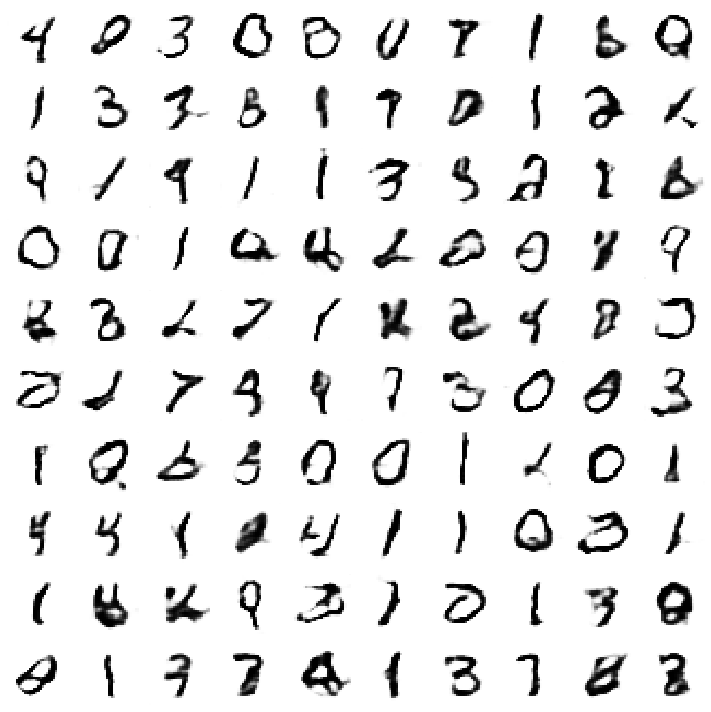

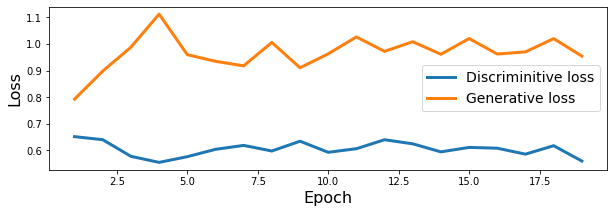

--------------- Epoch 20 ---------------


100%|██████████| 239/239 [00:05<00:00, 43.68it/s]


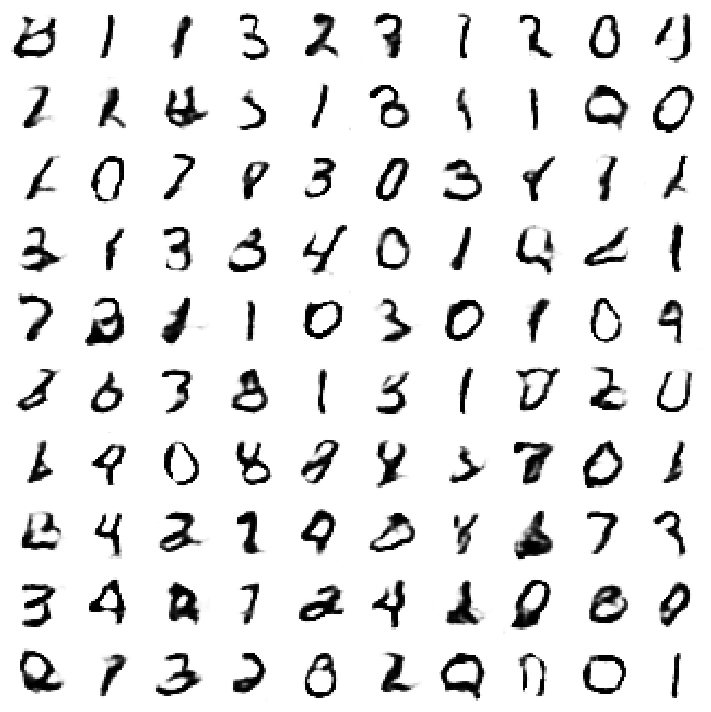

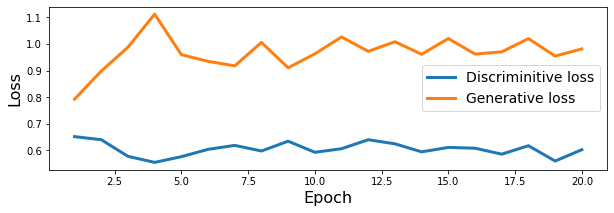

--------------- Epoch 21 ---------------


100%|██████████| 239/239 [00:05<00:00, 42.80it/s]


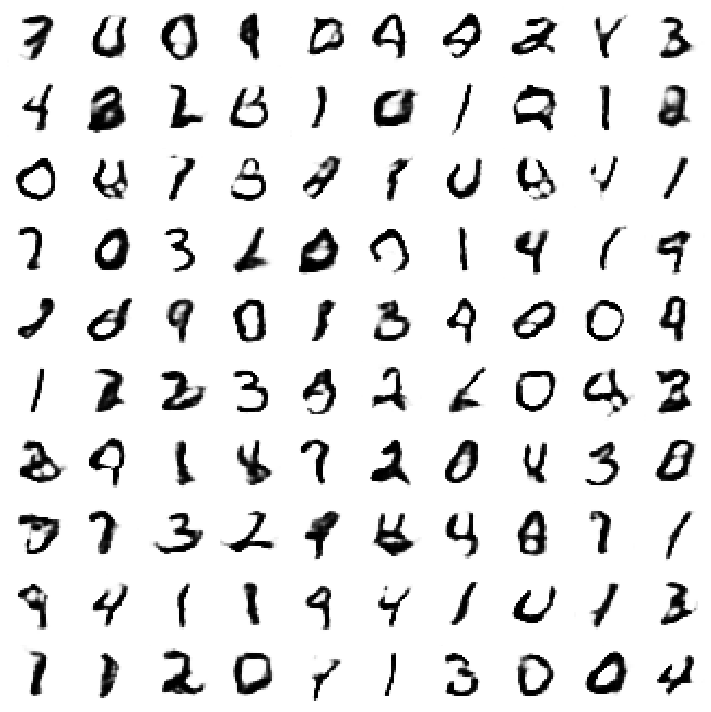

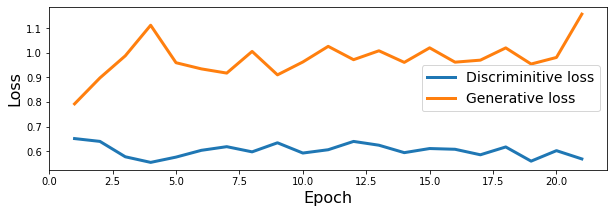

--------------- Epoch 22 ---------------


100%|██████████| 239/239 [00:05<00:00, 42.51it/s]


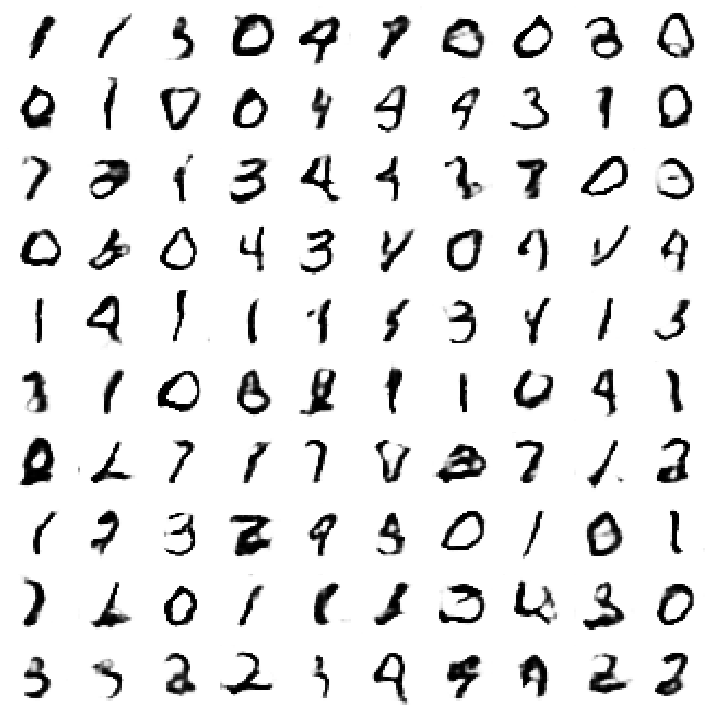

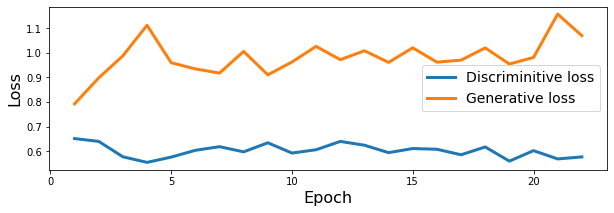

--------------- Epoch 23 ---------------


100%|██████████| 239/239 [00:05<00:00, 41.73it/s]


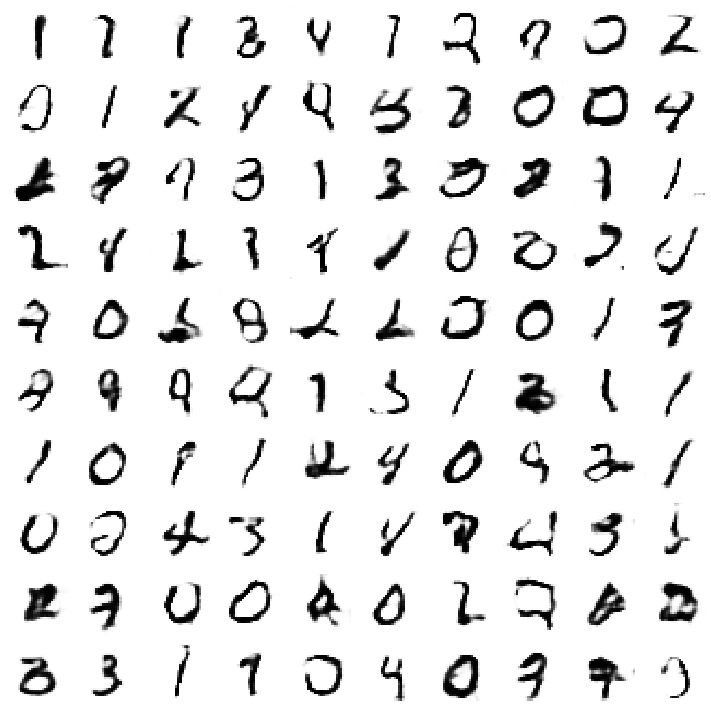

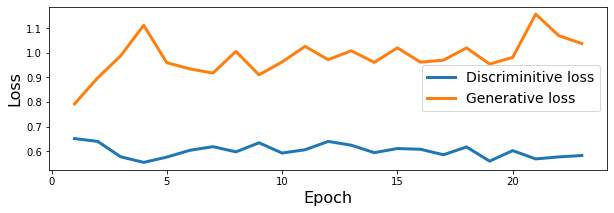

--------------- Epoch 24 ---------------


100%|██████████| 239/239 [00:05<00:00, 42.28it/s]


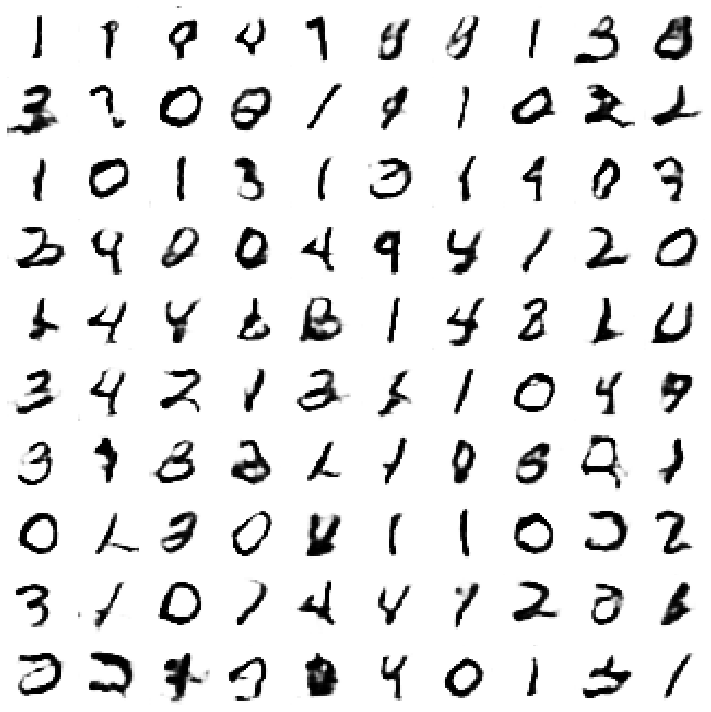

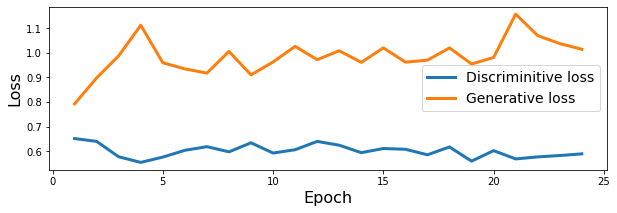

--------------- Epoch 25 ---------------


100%|██████████| 239/239 [00:05<00:00, 41.27it/s]


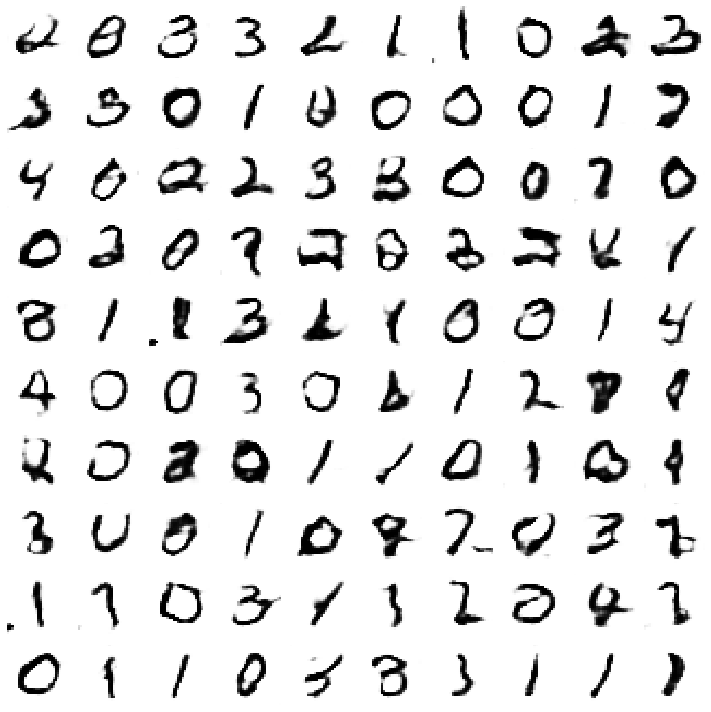

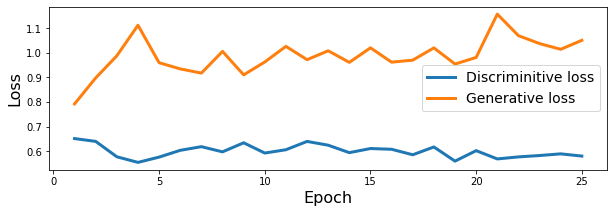

--------------- Epoch 26 ---------------


100%|██████████| 239/239 [00:05<00:00, 41.45it/s]


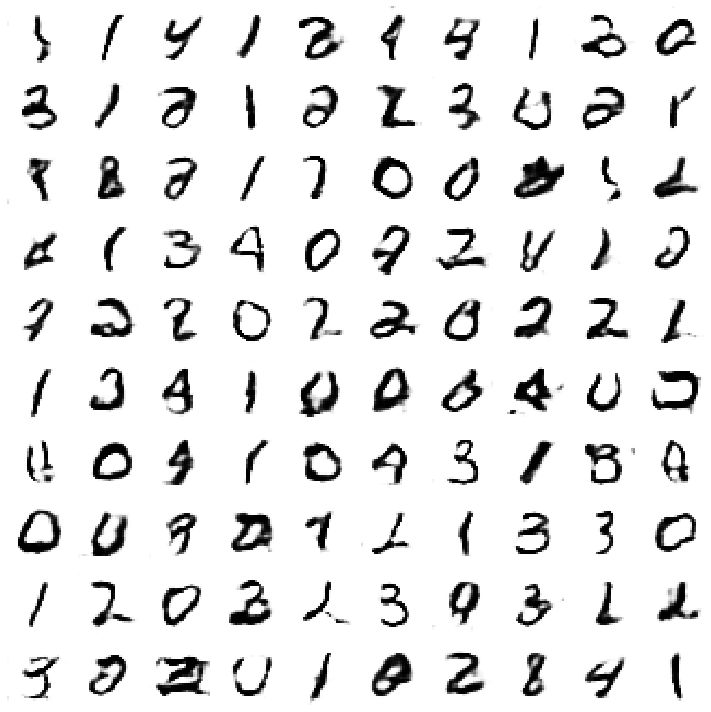

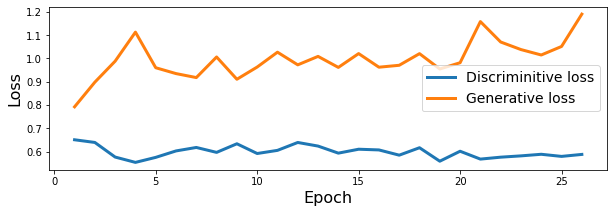

--------------- Epoch 27 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.41it/s]


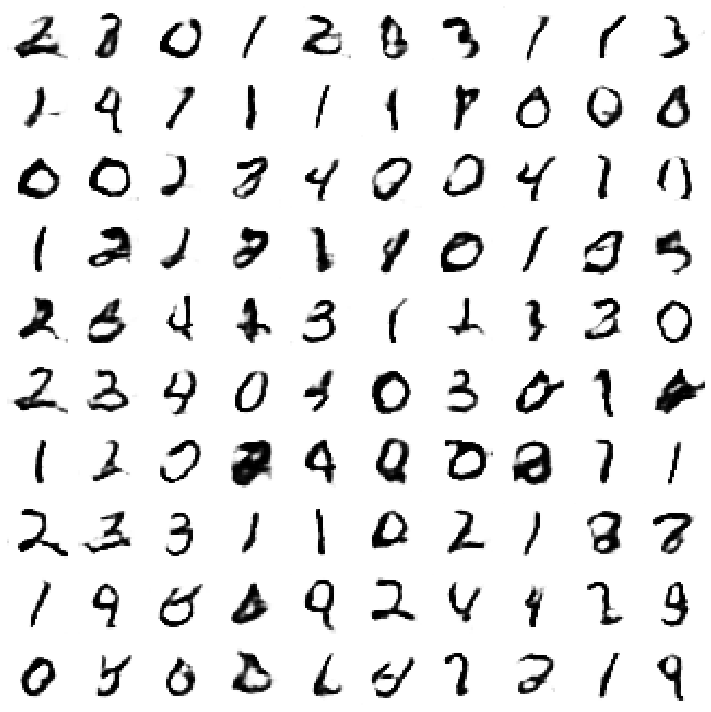

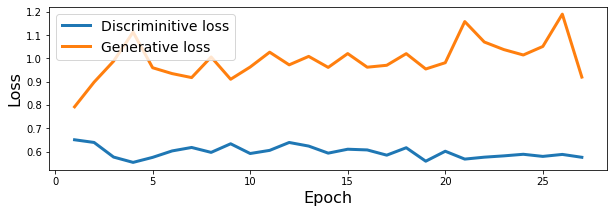

--------------- Epoch 28 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.68it/s]


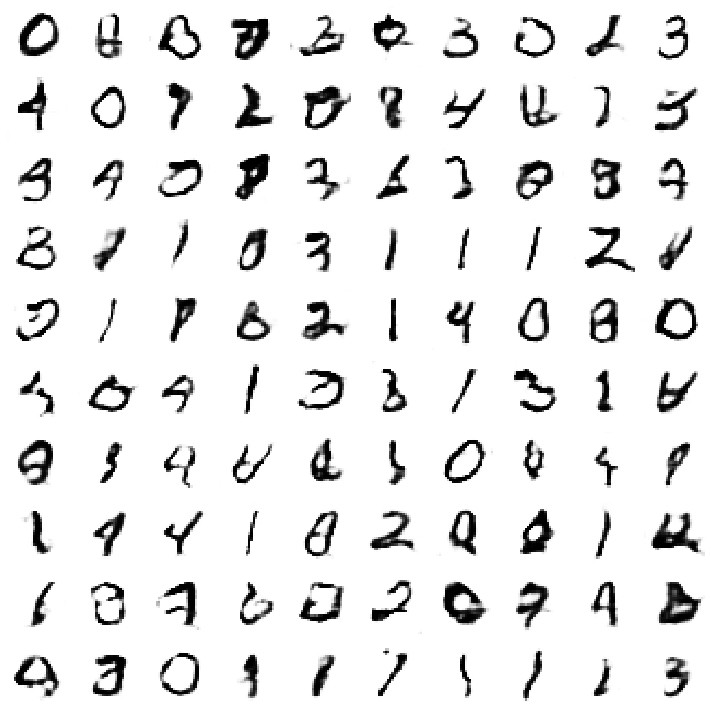

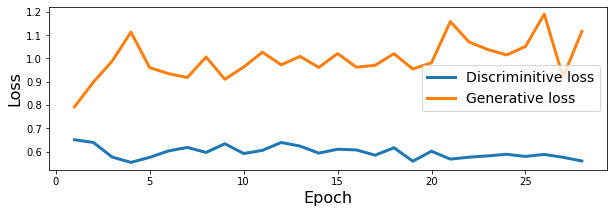

--------------- Epoch 29 ---------------


100%|██████████| 239/239 [00:05<00:00, 41.51it/s]


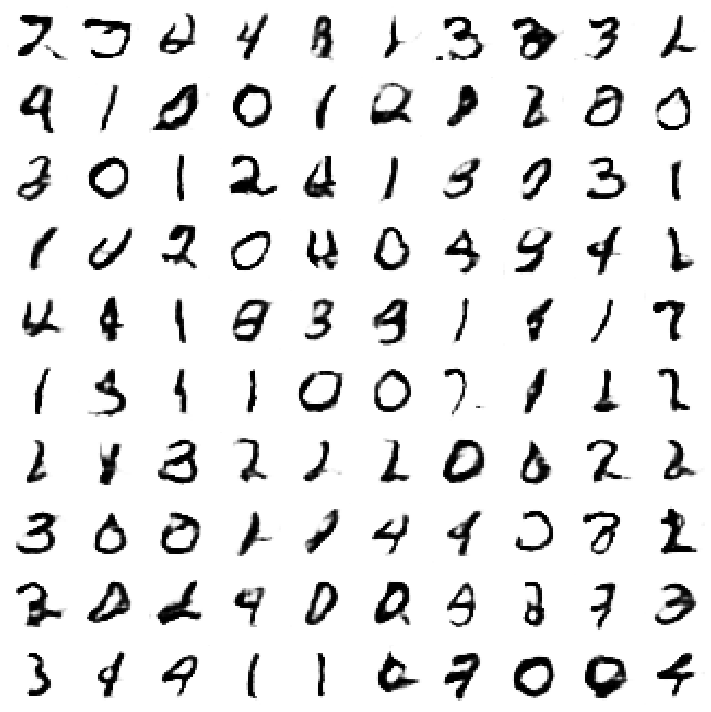

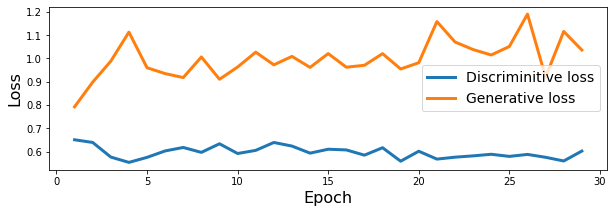

--------------- Epoch 30 ---------------


100%|██████████| 239/239 [00:06<00:00, 39.77it/s]


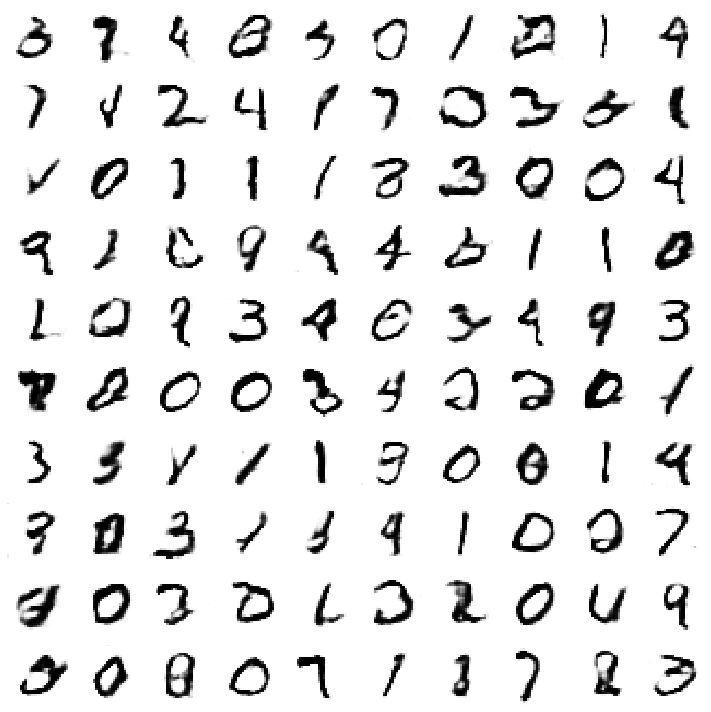

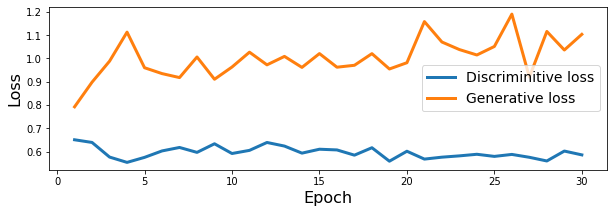

--------------- Epoch 31 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.61it/s]


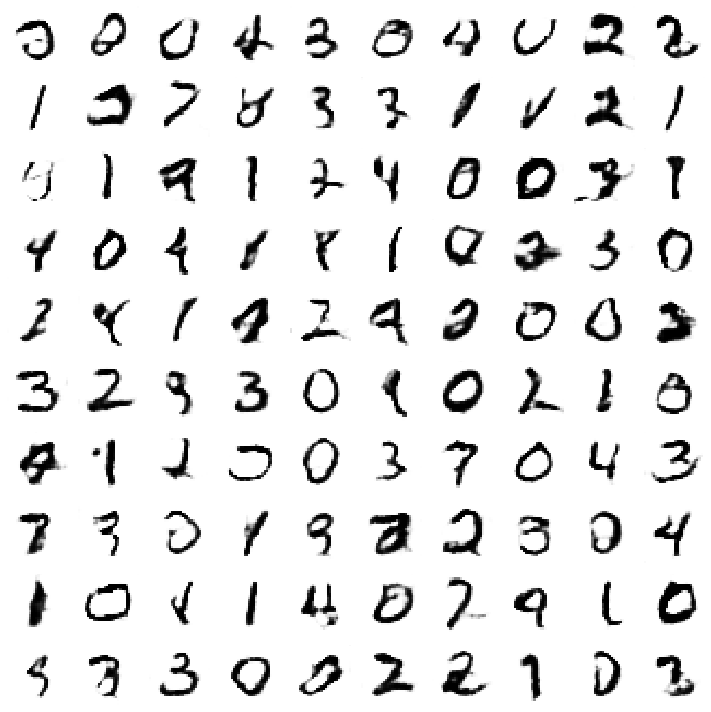

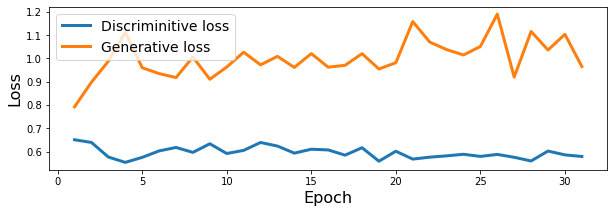

--------------- Epoch 32 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.11it/s]


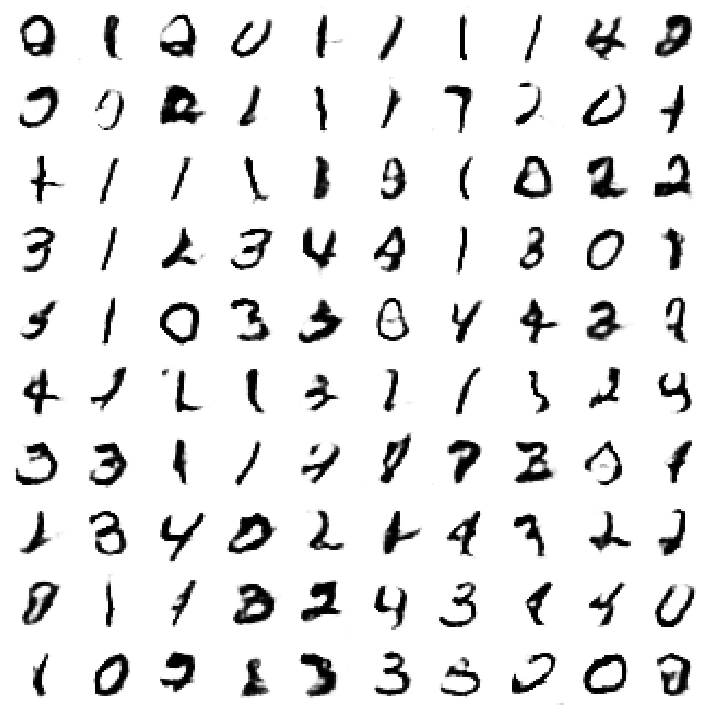

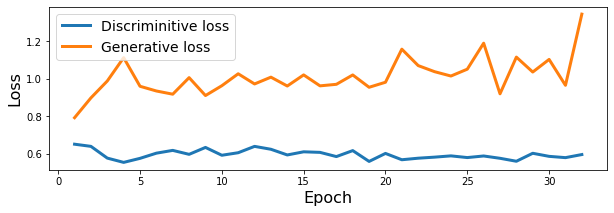

--------------- Epoch 33 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.98it/s]


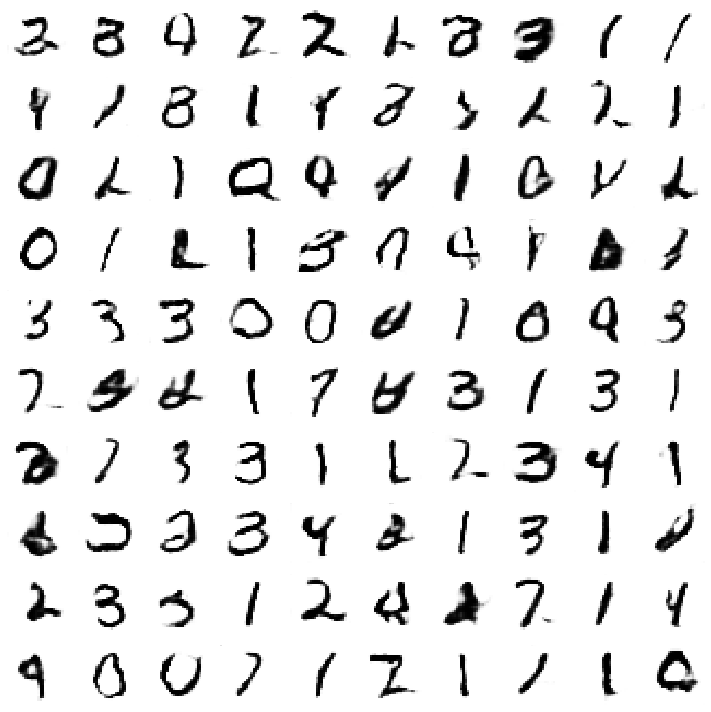

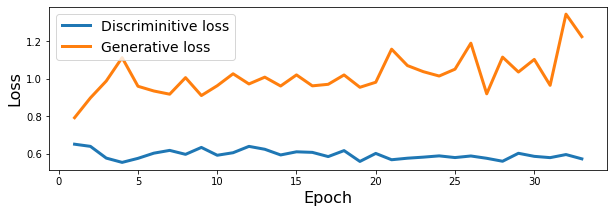

--------------- Epoch 34 ---------------


100%|██████████| 239/239 [00:05<00:00, 41.08it/s]


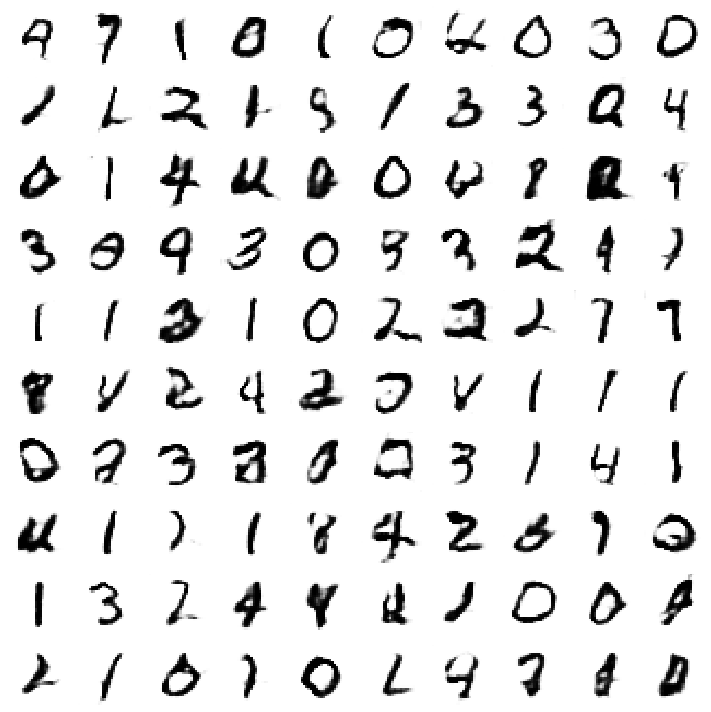

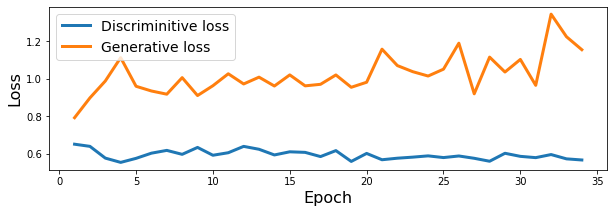

--------------- Epoch 35 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.49it/s]


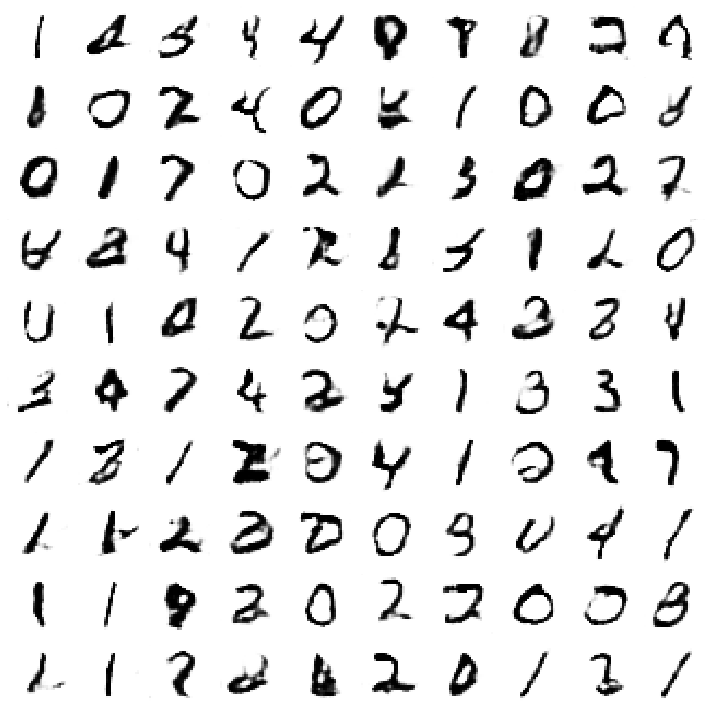

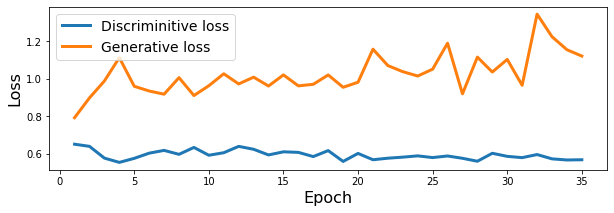

--------------- Epoch 36 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.67it/s]


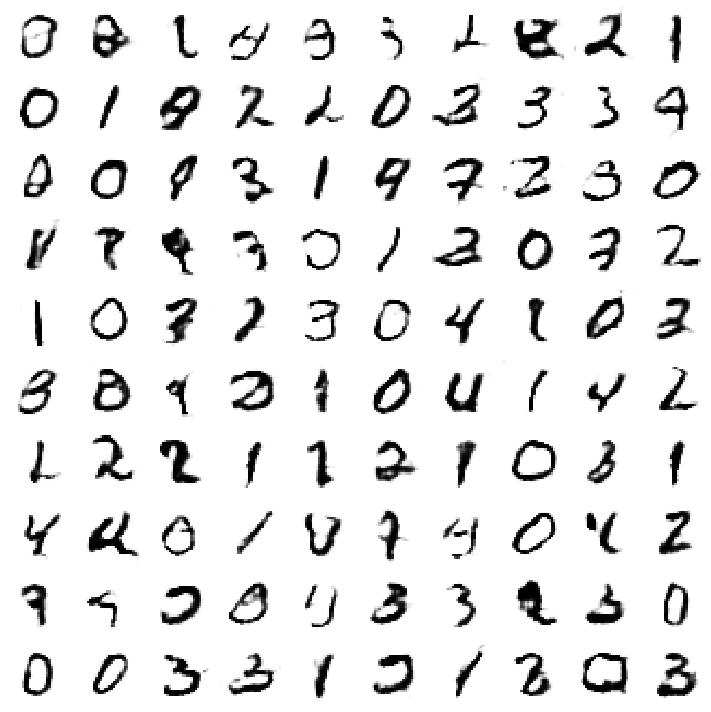

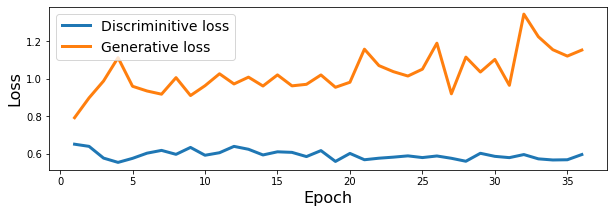

--------------- Epoch 37 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.29it/s]


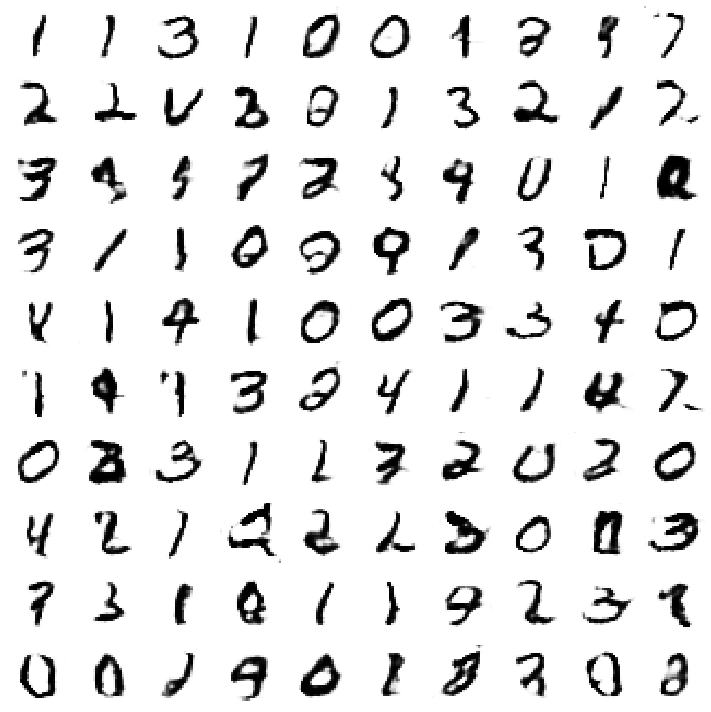

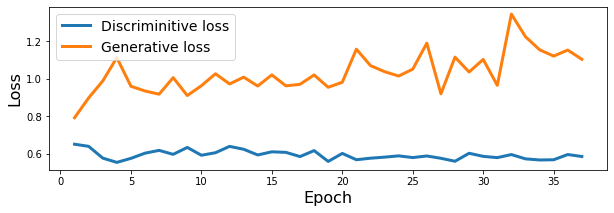

--------------- Epoch 38 ---------------


100%|██████████| 239/239 [00:05<00:00, 40.30it/s]


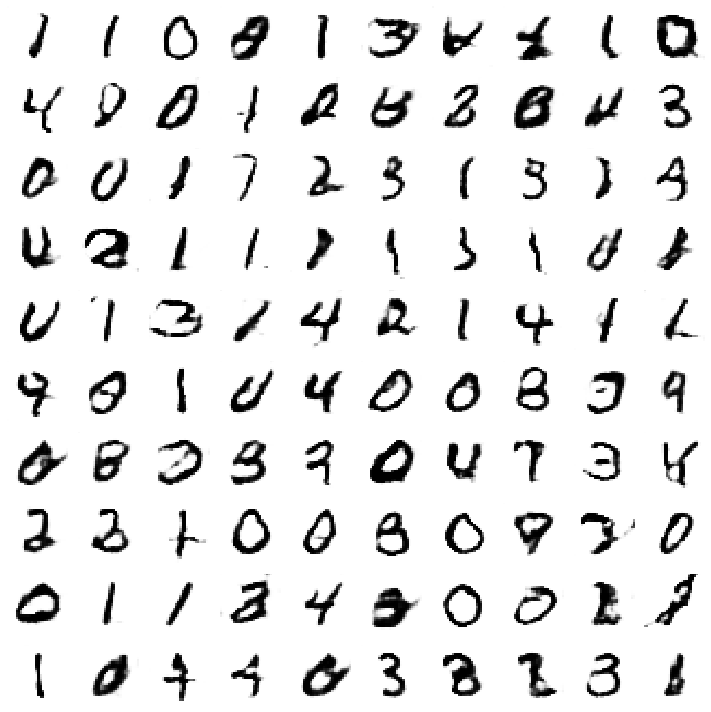

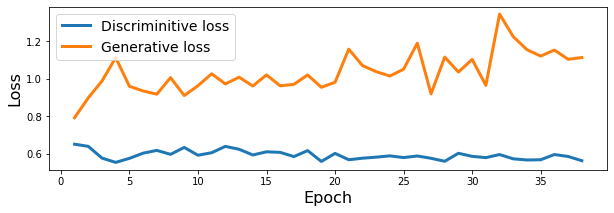

--------------- Epoch 39 ---------------


100%|██████████| 239/239 [00:06<00:00, 38.05it/s]


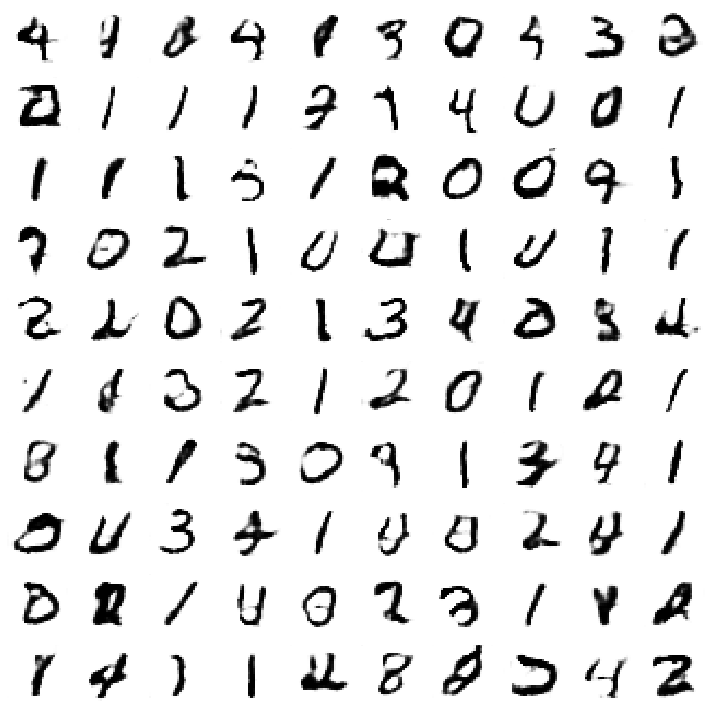

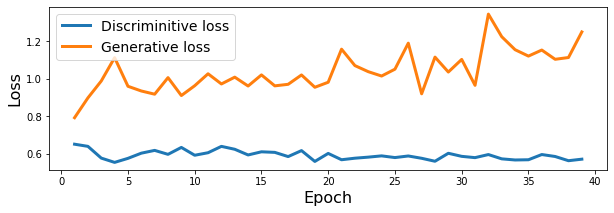

--------------- Epoch 40 ---------------


100%|██████████| 239/239 [00:06<00:00, 39.83it/s]


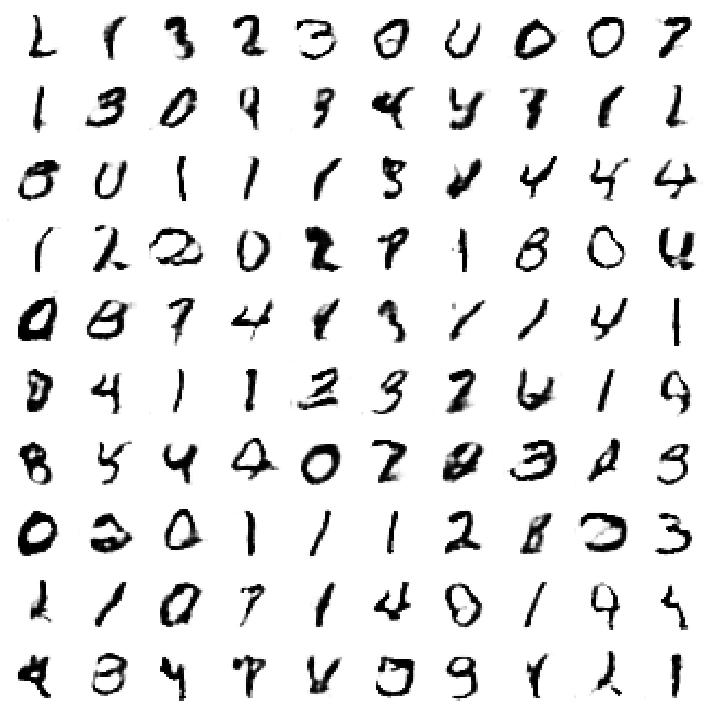

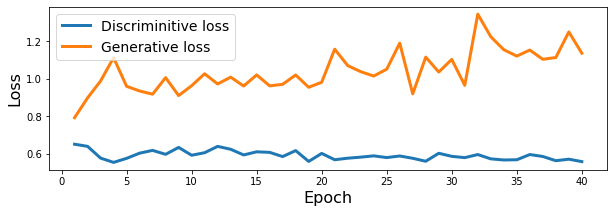

--------------- Epoch 41 ---------------


100%|██████████| 239/239 [00:06<00:00, 37.84it/s]


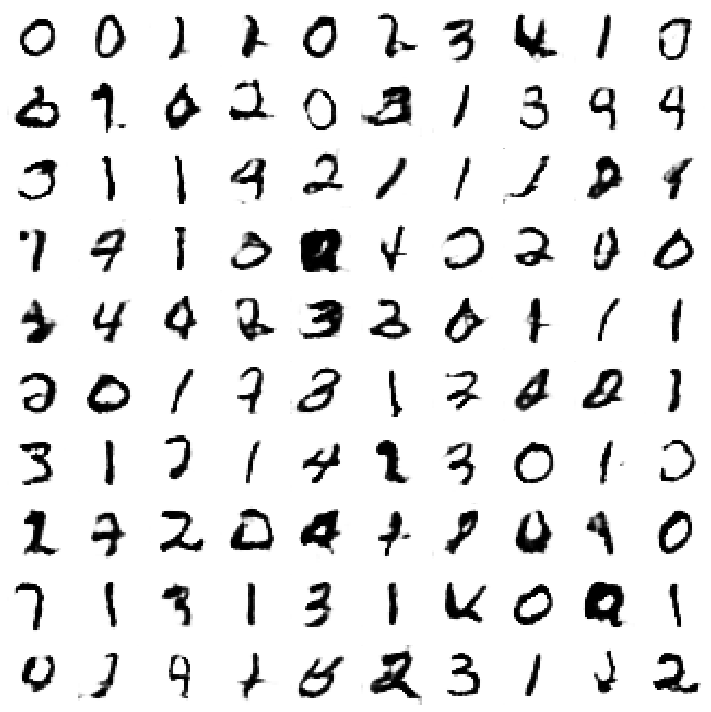

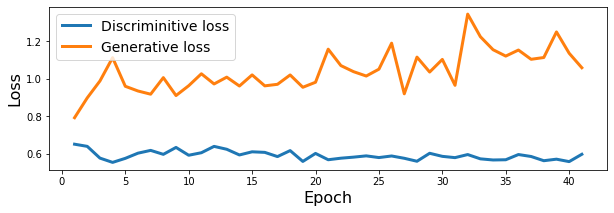

--------------- Epoch 42 ---------------


100%|██████████| 239/239 [00:06<00:00, 37.33it/s]


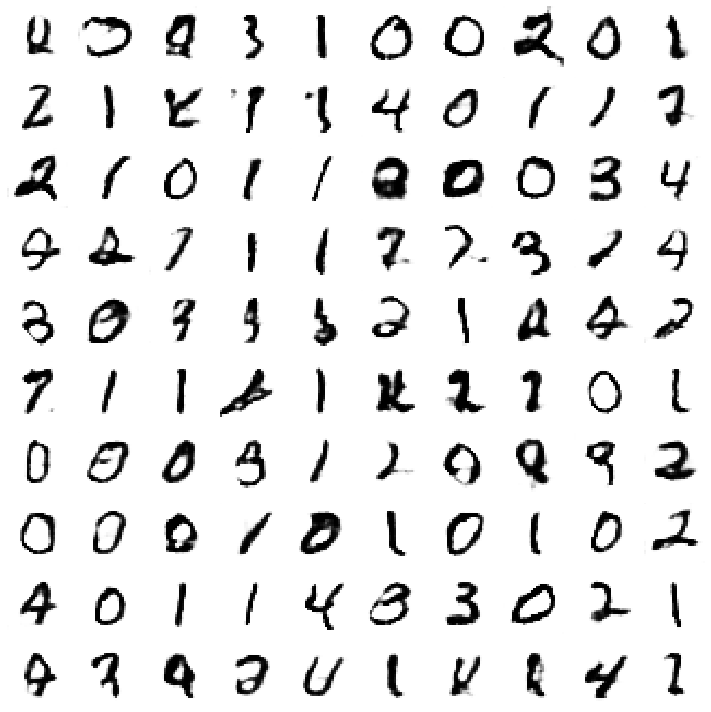

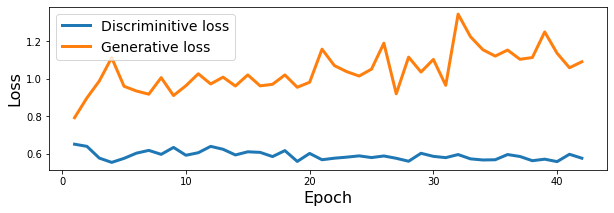

--------------- Epoch 43 ---------------


100%|██████████| 239/239 [00:06<00:00, 38.54it/s]


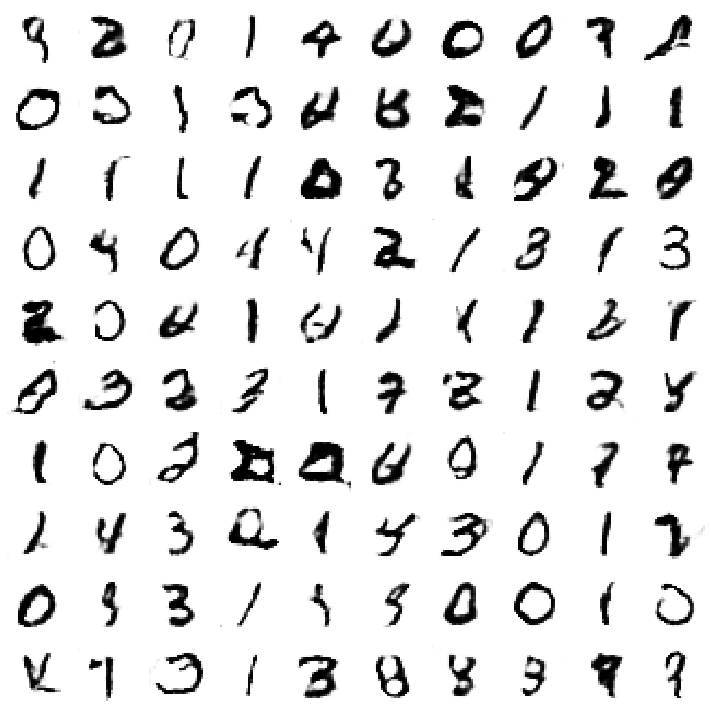

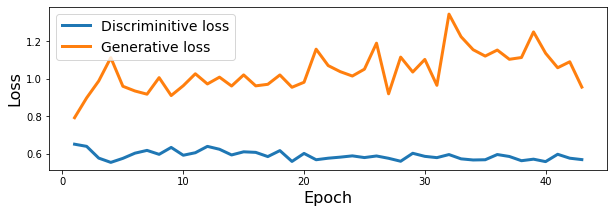

--------------- Epoch 44 ---------------


100%|██████████| 239/239 [00:06<00:00, 37.31it/s]


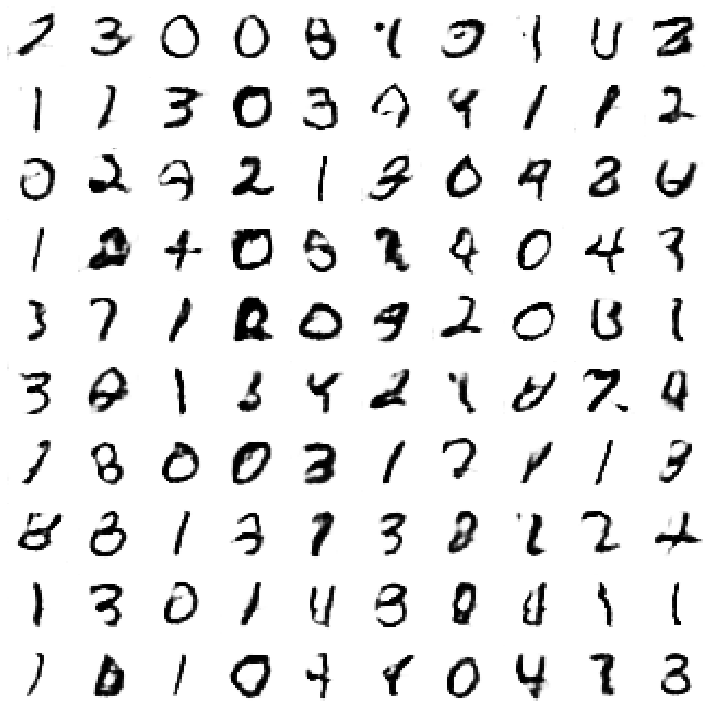

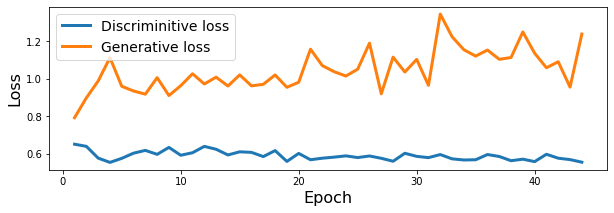

--------------- Epoch 45 ---------------


100%|██████████| 239/239 [00:06<00:00, 37.49it/s]


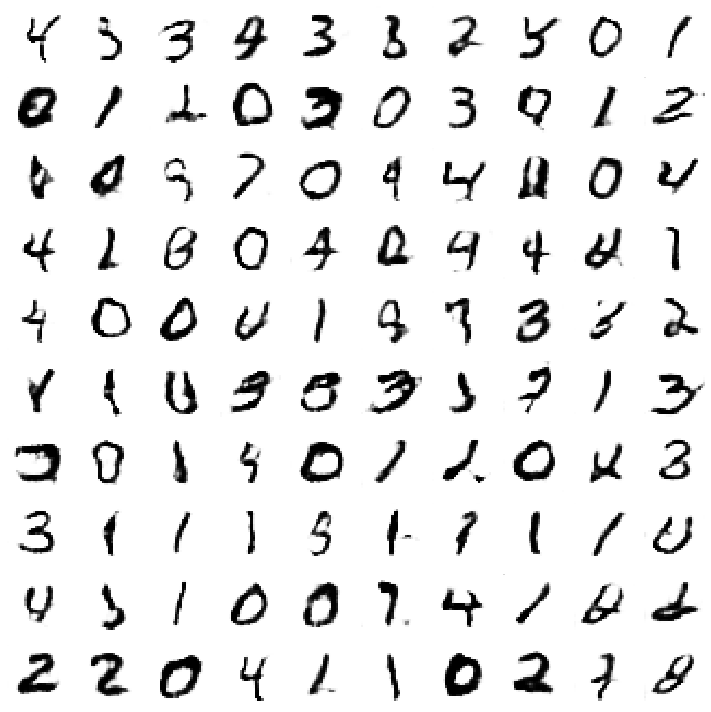

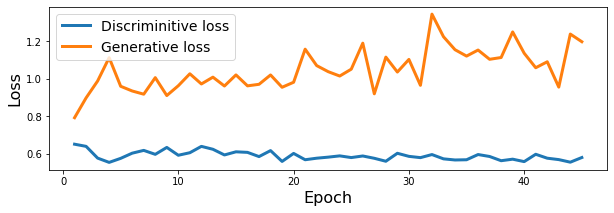

--------------- Epoch 46 ---------------


100%|██████████| 239/239 [00:06<00:00, 36.62it/s]


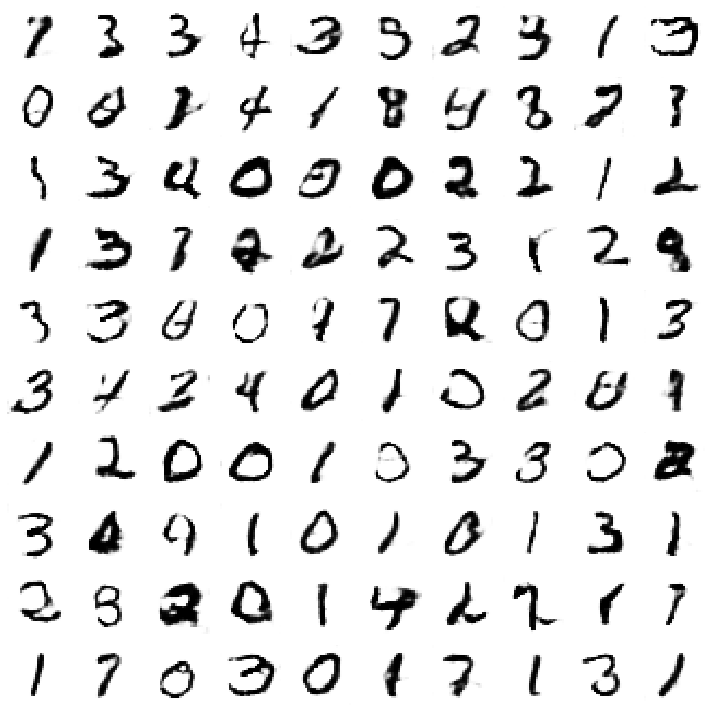

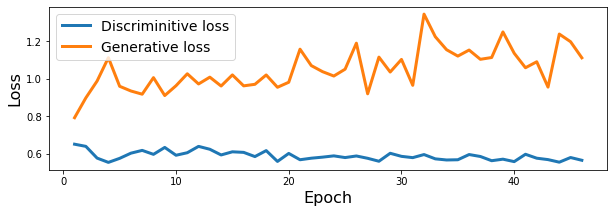

--------------- Epoch 47 ---------------


100%|██████████| 239/239 [00:06<00:00, 35.95it/s]


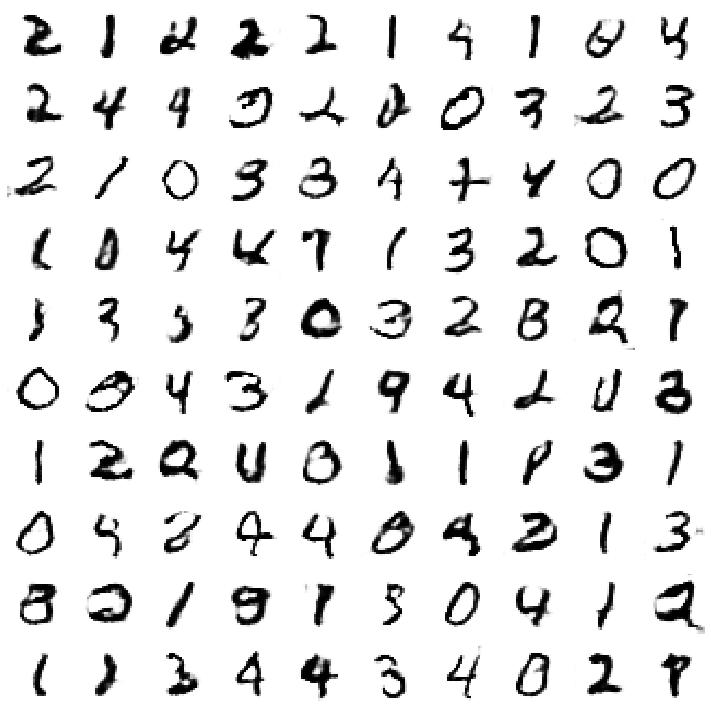

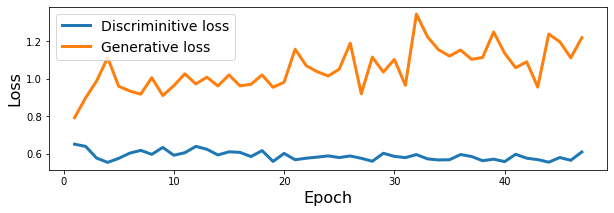

--------------- Epoch 48 ---------------


100%|██████████| 239/239 [00:06<00:00, 36.17it/s]


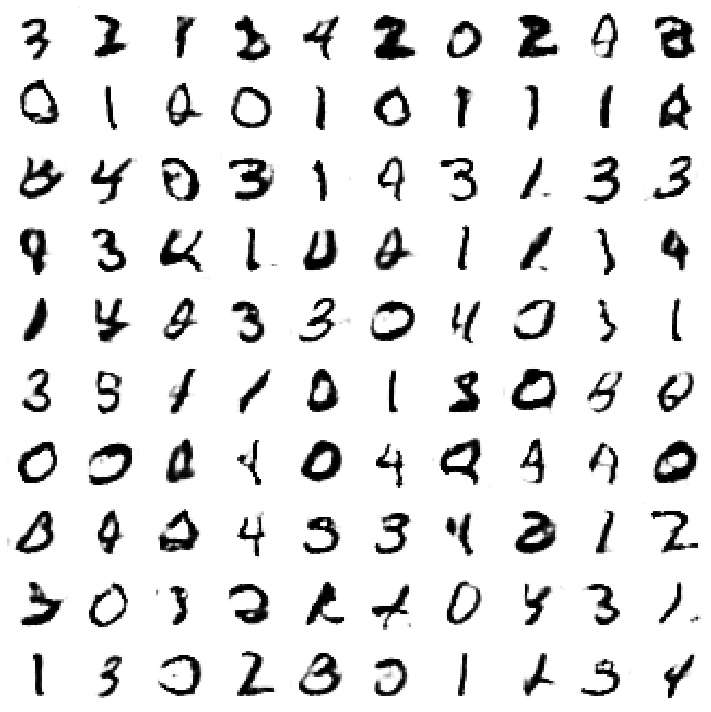

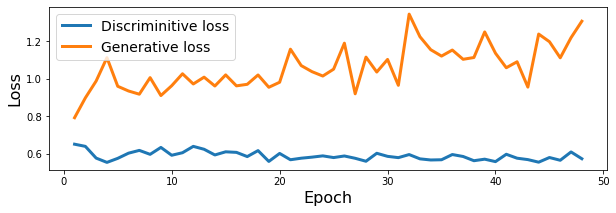

--------------- Epoch 49 ---------------


100%|██████████| 239/239 [00:06<00:00, 35.73it/s]


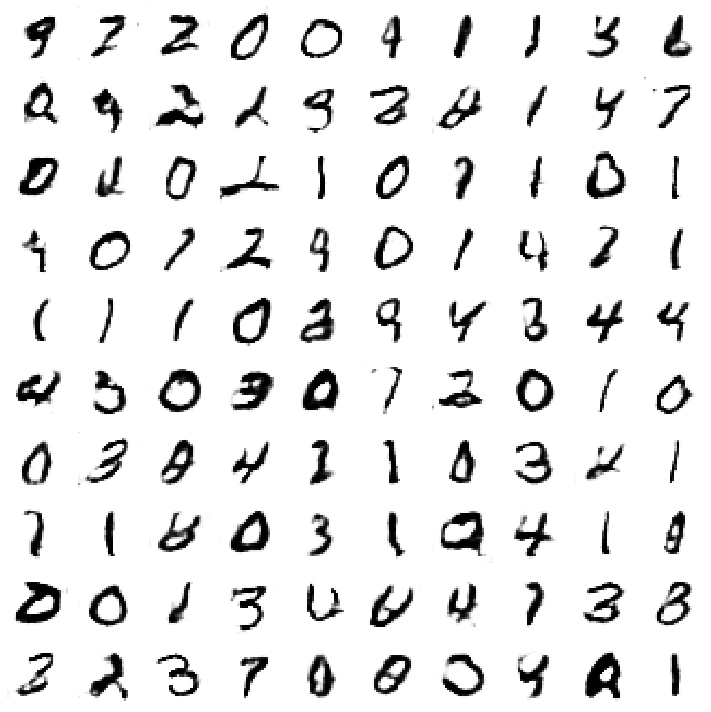

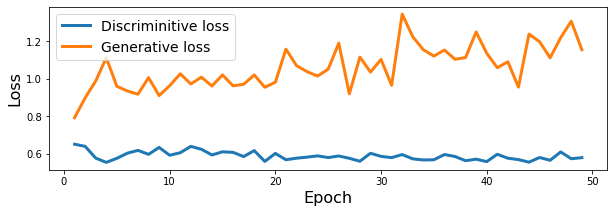

--------------- Epoch 50 ---------------


100%|██████████| 239/239 [00:06<00:00, 34.82it/s]


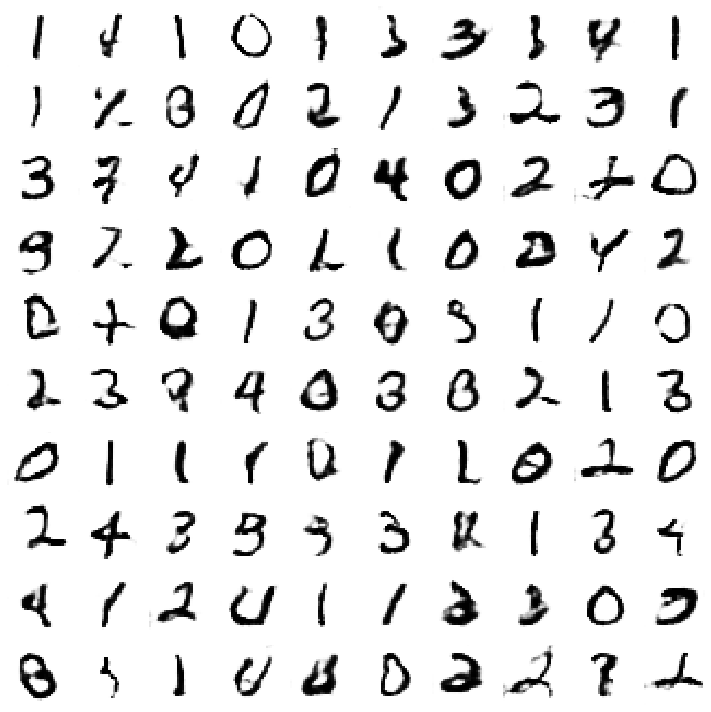

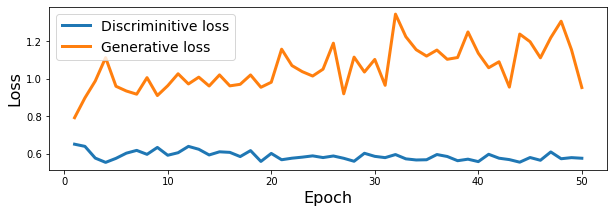

In [ ]:
epochs=50
batchSize=128
epocas_refrescar_grafica=1

batchCount = len(X_train) // batchSize
print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batchCount)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        imageBatch = X_train[np.random.randint(0, len(X_train), size=batchSize)]
        
        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])
        
        # Labels for generated and real data
        # los primeros batchSize ejemplos tienen etiqueta 0.9
        # (imagen real)
        # Los últimos batchSize ejemplos tienen etiqueta 0 (fake)
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9
        
        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)
        
        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
        
    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    
    if (e==1) or ((e%epocas_refrescar_grafica)==0):
        plotGeneratedImages(e)
        if SAVE_INTERMEDIATE_DATA:
            saveModels(e)
    if (e%epocas_refrescar_grafica)==0:
        plotLoss(e)

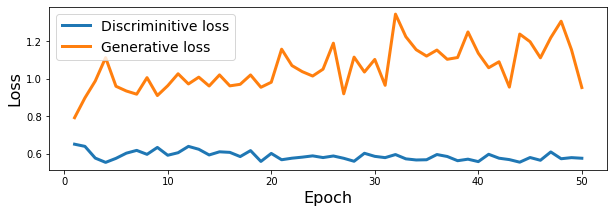

In [ ]:
# Plot losses from every epoch
plotLoss(e)

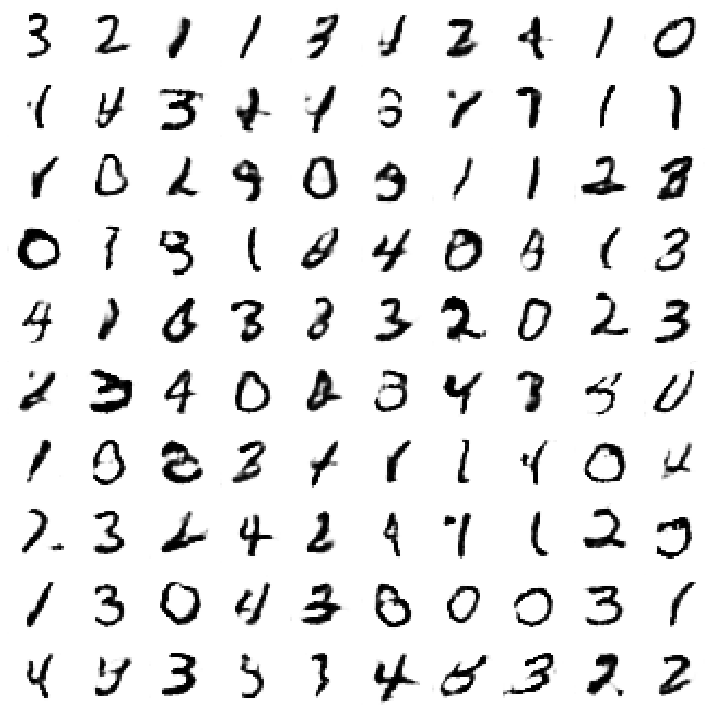

In [ ]:
# Generación de 100 imágenes nuevas:

n_imagenes = 100

noise = np.random.normal(0, 1, size=[n_imagenes, randomDim])
generatedImages = generator.predict(noise)
plotGeneratedImages(e+1)

Ahora generamos un conjunto de vectores de entrada a la GAN. Cada vector de entrada tiene **randomDim** componentes:

In [ ]:
nrows = 5
ncols = 10
input0 = np.zeros((nrows*ncols, randomDim))
caso = 0
for i in range(nrows):
    for j in range(ncols):
        input_id = i+10
        input0[caso,input_id] = -2+4*j/(ncols-1)
        caso = caso + 1
        


In [ ]:
# Vamos a mostrar los resultados obtenidos para el conjunto de vectores
# de entrada en una matriz de nfilas * ncols:
nfilas = 5
ncols  = 10

# Inicializo a 0 el conjunto de vectores de entrada a la GAN:
input0 = np.zeros((nfilas*ncols, randomDim))

# Termino de calcular el conjunto de vectores de entrada.
# La idea es que en cada fila las componentes diferentes de cero
# son las mismas, y sus valores cambian de columna a columna:

nvector = 0
for i in range(nfilas):
    # Qué componentes de las randomDim se van a perturbar:
    componentes_pert = range(i,i+10+1)
    for j,x in enumerate(np.linspace(-2, 2, ncols)):
        input_id = i+0
        input0[nvector][componentes_pert] = x
        nvector = nvector + 1

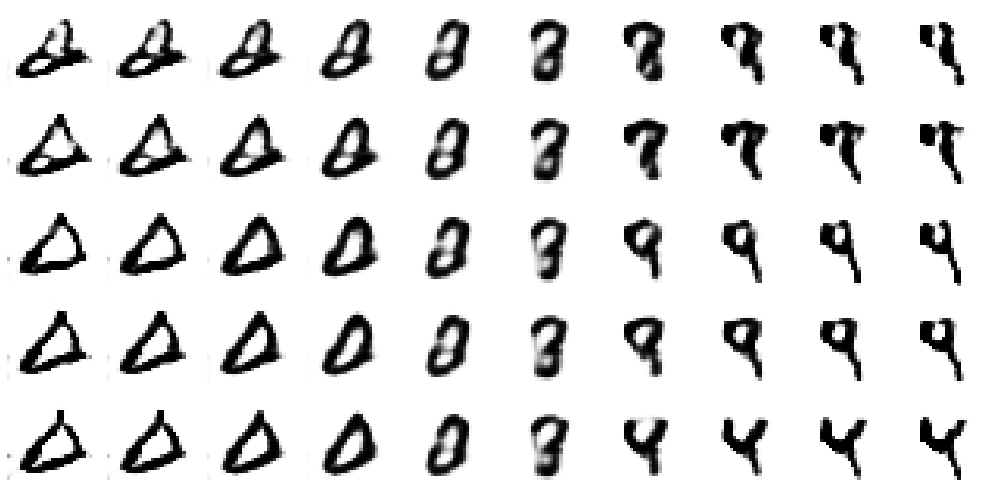

In [ ]:
generatedImages = generator.predict(input0)
plotImages(generatedImages, nfilas, ncols, figsize=(14,7))

### Qué pasa con los números híbridos??

Ver que hay varios números híbridos. Esto tiene sentido porque estoy entrenando el generador con números aleatorios sacados de una distribución normal. Esta es una distribución continua, pero los números son valores discretos (10). Esto significa que en la continuidad de la normal cuando me acerco a la frontera entre dos números voy a tener como un "híbrido".

Para solucionarlo hay dos maneras: (1) GANN condicionales (2) Hacer una GANN por cada clase.

In [ ]:
generatedImages.shape

In [ ]:
# Para grabar las redes a fichero:

generator.save("./dcgan_generator.h5")
generator.save_weights("./dcgan_generator_weights.h5")
discriminator.save("./dcgan_discriminator.h5")
discriminator.save_weights("./dcgan_discriminator_weights.h5")
gan.save("./dcgan_gan.h5")
gan.save_weights("./dcgan_gan_weights.h5")

Para descargar el modelo a local si estamos en Colab:

In [ ]:
if COLAB:
    from google.colab import files
    files.download('./dcgan_generator.h5')
    files.download('./dcgan_generator_weights.h5')
    files.download('./dcgan_discriminator.h5')
    files.download('./dcgan_discriminator_weights.h5')
    files.download('./dcgan_gan.h5')
    files.download('./dcgan_gan_weights.h5')

Si quisiésemos realizar **data augmentation** desde otro script, haríamos lo siguiente:

In [ ]:
from keras.models import load_model

model_data_augmentation = load_model("./dcgan_generator.h5")

In [ ]:
model_data_augmentation.summary()

In [ ]:
model_data_augmentation.input_shape

In [ ]:
numero_patrones_sinteticos = 1000
tam_entrada_generador = model_data_augmentation.input_shape[-1]
input_gen = np.random.randn(numero_patrones_sinteticos, tam_entrada_generador)

patrones_nuevos = model_data_augmentation.predict(input_gen)

In [ ]:
patrones_nuevos.shape

In [ ]:
plotImages(patrones_nuevos[:20], nfilas, ncols, figsize=(14,7))